**<h2>Computing Water Potential Energy Surface Using Behler and Parinello Symmetry Functions** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

Loading the data (energies and geometries) for 1000 water molecule configurations in .xyz form

In [2]:
energies = np.genfromtxt('./water/energies.txt')
print("Energies file has",np.shape(energies),"entries")
#geometry_data =  read('./water/structures.xyz',index=':')
#print("Geometry file has",np.shape(geometry_data),"entries")
#print(geometry_data[0])
#geometry_data = np.array(geometry_data)

Energies file has (1000,) entries


In [3]:
# see https://education.molssi.org/python-data-analysis/01-numpy-arrays/index.html
#https://stackoverflow.com/questions/23353585/got-1-columns-instead-of-error-in-numpy

file_location = os.path.join('water', 'structures.xyz')
xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode',invalid_raise = False)
# where invalid_raise = False was used to skip all lines in the xyz file that only have one column
symbols = xyz_file[:,0]
coordinates = (xyz_file[:,1:-1])
coordinates = coordinates.astype(np.float)

#print(symbols)
#print(coordinates)

<ipython-input-3-c38e52de7b08>:5: ConversionWarning: Some errors were detected !
    Line #6 (got 1 columns instead of 5)
    Line #11 (got 1 columns instead of 5)
    Line #16 (got 1 columns instead of 5)
    Line #21 (got 1 columns instead of 5)
    Line #26 (got 1 columns instead of 5)
    Line #31 (got 1 columns instead of 5)
    Line #36 (got 1 columns instead of 5)
    Line #41 (got 1 columns instead of 5)
    Line #46 (got 1 columns instead of 5)
    Line #51 (got 1 columns instead of 5)
    Line #56 (got 1 columns instead of 5)
    Line #61 (got 1 columns instead of 5)
    Line #66 (got 1 columns instead of 5)
    Line #71 (got 1 columns instead of 5)
    Line #76 (got 1 columns instead of 5)
    Line #81 (got 1 columns instead of 5)
    Line #86 (got 1 columns instead of 5)
    Line #91 (got 1 columns instead of 5)
    Line #96 (got 1 columns instead of 5)
    Line #101 (got 1 columns instead of 5)
    Line #106 (got 1 columns instead of 5)
    Line #111 (got 1 columns instead

In [4]:
## Alternatively loading the data in .npy form
# # The data was downloaded from http://www.quantum-machine.org/datasets/ (Densities dataset--> water.zip)
# # The data includes energies, densities and structure for water molecules
# #For each dataset, structures are given in with positions in Bohr and the energies are given in kcal/mol 
# energy_data = np.load('./water_102/dft_energies.npy')
# print("Energies file has",np.shape(energy_data),"entries")
# geometry_data =  np.load('./water-2/water_102/structures.npy')
# print("Geometry file has",np.shape(geometry_data),"entries")
# print(type(energy_data))
# print(type(geometry_data))

In [5]:
print(np.shape(coordinates))
print(type(coordinates))
print(coordinates[0])
print(coordinates[1])
print(coordinates[2])

print('gfjkhgfjhgfkgh')
print(coordinates[3])
print(coordinates[4])
print(coordinates[5])

print(energies[0])
# There is 1000 water molecules and each of them consists of 3 atoms, so we have 3000 atoms in total and each
# of them has 3 coordinates.
# Thus the coordinates array has 3000 lines, each of them corresponding to one atom (the first three lines
# correspopnd to the first water molecule) and 3 columns corresponding to the x, y and z coordinates respectively.

(3000, 3)
<class 'numpy.ndarray'>
[0.         0.769767   0.55746937]
[ 0.         -0.71017975  0.50340914]
[ 0.         -0.0037242  -0.06630491]
gfjkhgfjhgfkgh
[0.         0.77715107 0.59586089]
[ 0.         -0.77642641  0.59515778]
[ 0.000000e+00 -4.529000e-05 -7.443867e-02]
-13815.2523726009


**<h2>Cutoff Function** 
    $$f_c(R_{ij}) = 
    \begin{cases}
        0.5 \times \big[\cos\big(\frac{\pi R_{ij}}{R_c}\big)+1\big]  & \text{for } R_{ij} \leq R_c\\
        0  & \text{for } R_{ij} > R_c
    \end{cases}
    $$
    
In the Behler and Parinello paper the Cutoff radius $R_c$ was taken to be $6$  Ångströms, or 11.3384 Bohr radii. (Remember, 1 Ångström is $10^{-10}$m)

In [6]:
def fc(R,Rc):
    if R <= Rc:
        fcutoff = 0.5 * (np.cos(np.pi*R/Rc)+1)
    else:
        fcutoff = 0
    return fcutoff

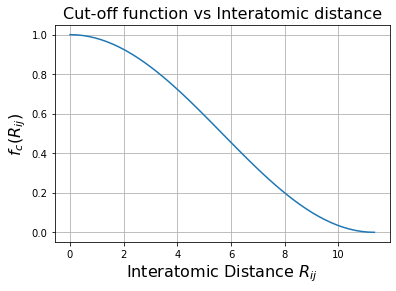

In [7]:
# Plotting fc as a function of interatomic distance Rij

Rc  = 11.3384 # Bohr

Rij     = np.linspace(0,Rc)
fcutoff = np.zeros(np.size(Rij))

for i in range(np.size(Rij)):
    fcutoff[i] = fc(Rij[i],Rc)

plt.plot(Rij,fcutoff)
plt.title('Cut-off function vs Interatomic distance', fontsize=16)
plt.xlabel('Interatomic Distance $R_{ij}$', fontsize=16)
plt.ylabel('$f_c(R_{ij})$', fontsize=16)
plt.grid()

**<h2>Pairwise Distances**

$$Dp = \begin{bmatrix} R_{00} & R_{01} & R_{02} \\ R_{10} & R_{11} & R_{12} \\ R_{20} & R_{21} & R_{22} \end{bmatrix} = \begin{bmatrix} 0 & R_{01} & R_{02} \\ R_{01} & 0 & R_{12} \\ R_{02} & R_{12} & 0 \end{bmatrix} $$

In [8]:
i = 0                                # i-th water molecule
coord = coordinates[3*i:3*(i+1),:]   # Let's take the coordinates of the ith water molecule in our dataset and compute
                                     # pairwise distances between all of its 3 atom

def pairwise_distances(coord):                       # we pass in the coordinates of the 3 atoms in the water molecule
    pairwise_dist_matrix = np.zeros(np.shape(coord))       # Initialise the matrix
    N = len(coord)
    for i in range(0,N-1):
#        print('i=',i)
        for j in range(i+1,N):
#            print(j)
#            pairwise_dist_matrix[i][j] = \
#            np.sqrt(  (coord[i][0] - coord[j][0] )**2 + (coord[i][1] - coord[j][1] )**2 +(coord[i][2] - coord[j][2] )**2   )
            pairwise_dist_matrix[i][j] =  np.sqrt(sum( (coord[i,:] - coord[j,:])**2 ))
            pairwise_dist_matrix[j][i] = pairwise_dist_matrix[i][j]

    return pairwise_dist_matrix

Dp = pairwise_distances(coord)
print(Dp)



[[0.         1.48093379 0.99367147]
 [1.48093379 0.         0.9075536 ]
 [0.99367147 0.9075536  0.        ]]


**<h2>From Cartesian to Generalised Coordinates**

**<h3>Radial Symmetry Functions**
    
<h3>$$G_i^1 = \sum_{j \neq i}^{\text{all}} e^{-\eta (R_{ij}-R_s)^2} f_c (R_{ij})$$

In [9]:
heta = 0.1
Rs   = 0
N    = len(coord)


def radial_BP_symm_func(Dp,N,heta,Rs):
    G_mu1 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)
    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(0,i):
            G_mu1[i] = G_mu1[i] + np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
        for j in range(i+1,N):
            G_mu1[i] = G_mu1[i] +  np.exp(-heta*(Dp[i][j]-Rs)**2)* fc(Dp[i][j],Rc) 
    return G_mu1

Gmu1 = radial_BP_symm_func(Dp,N,heta,Rs)
print(Gmu1)

[1.65865495 1.67618952 1.79537284]


**<h3> Angular Symmetry Functions**

$$G_i^2 = 2^{1-\zeta} \sum_{j,k \neq i}^{\text{all}} (1+\lambda \cos \theta_{ijk})^\zeta \times e^{-\eta (R_{ij}^2+R_{ik}^2+R_{jk}^2 )} f_c (R_{ij})f_c (R_{ik})f_c (R_{jk})$$
    
with parameters $\lambda = +1, -1$, $\eta$ and $\zeta$

In [10]:
lambdaa = 1     #1
zeta    = 0.2
heta    = 0.1

N = len(coord)

def angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta):
    G_mu2 = np.zeros(len(Dp))           # since we are dealing with water molecules the dimension of G will be 3 (H,H,O)

    for i in range(N):                 # to avoid using an if statement (if i not equal j), break the sum in two
        for j in range(N):           
            for k in range(N):
                if j != i and k !=i:
                    R_vec_ij = coord[i,:] - coord[j,:]
                    R_vec_jk = coord[i,:] - coord[k,:]
                    theta_ijk  = np.dot(R_vec_ij, R_vec_jk)/(Dp[i][j]*Dp[i][k])
                    G_mu2[i]   = G_mu2[i] + (  1 + lambdaa * np.cos(theta_ijk) )**zeta  \
                                * np.exp( -heta * (Dp[i][j]**2 + Dp[i][k]**2 + Dp[j][k]**2) ) \
                                * fc(Dp[i][j],Rc) * fc(Dp[i][k],Rc) * fc(Dp[j][k],Rc)            
        G_mu2[i]   = 2**(1-zeta) * G_mu2[i] 
    return G_mu2

Gmu2 = angular_BP_symm_func(coord,Dp,N,heta,Rs,lambdaa,zeta)
print(Gmu2)

[5.02506754 5.09386024 5.53493842]


**<h2>Training and Test Set**

In [11]:
a = np.ones(4)
print(a)

[1. 1. 1. 1.]


In [12]:
N                    = 3           # number of atoms per molecule
number_of_features   = 48           # number of features (symmetry functions) for each atom (we create one radial)
                                   # and one angular, but can create more by vaying the parameters η, λ, ζ, Rs etc.

heta   = np.linspace(0.01, 0.5, num=number_of_features)
random.shuffle(heta)

Rs     = np.linspace(0, 1, num=number_of_features)
random.shuffle(Rs)

lambdaa = np.ones(number_of_features)
random.shuffle(lambdaa)

zeta    = np.linspace(0, 0.5, num=number_of_features)
random.shuffle(zeta)


data_size            = 1000        # We have 1000 water molecule conformations
training_set_size    = 900



    
G = np.zeros((len(coordinates), number_of_features))  # we have 3000x2 features (2 symm funcs for ech of the 3000 atoms in the dataset)

for i in range(data_size):
    coord = coordinates[N*i:N*(i+1),:]
    Dp    = pairwise_distances(coord)
    for j in range(0,number_of_features,2):
        G[N*i:N*(i+1),j]   = radial_BP_symm_func(Dp,N,heta[j],Rs[j])     
        G[N*i:N*(i+1),j+1] = angular_BP_symm_func(coord,Dp,N,heta[j],Rs[j],lambdaa[j],zeta[j])
    
# Computing variance and mean on the training data only!
G_train = G[:training_set_size,:]
var  = np.var(G_train,axis=0)
mean = np.mean(G_train,axis=0)

# normalize all data (training and test), using training set mean and variance
for i in range(np.shape(G)[0]):
    for j in range(np.shape(G)[1]):
        G[i,j] = (G[i,j]-mean[j])/var[j]   


data_set = np.vsplit(G,1000)     # Going from a (3000,2) np.array to a (1000,3,2) list
#data_set = np.random.permutation(training_set)
data_set = torch.FloatTensor(data_set)          # Going from a (1000,3,2) list to a a (1000,3,2) tensor

# print(data_set[0])
# print(data_set[0][1][1])
labels = torch.FloatTensor(energies)            # turning energies into a (1000) tensor

# Splitting the dataset into training and test set
training_set         = data_set[:training_set_size]
test_set             = data_set[training_set_size:]

train_labels         = labels[:training_set_size]
test_labels          = labels[training_set_size:]

# Dataset
dataset = TensorDataset(training_set, train_labels)
#print(dataset[0])

# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                           shuffle=False, num_workers=2, drop_last=False) # ?????

print(np.shape(training_set))

torch.Size([900, 3, 48])


In [13]:
print(G)

[[ -4.08783084  -0.89249784  -9.44168273 ...  -1.30677902  -4.91625048
   -0.91279428]
 [ -2.13858935  -0.15767611  -5.0864075  ...  -0.23760614  -3.38258952
   -0.1632447 ]
 [ 10.75245039   3.48075869  26.25507166 ...   4.12402915  15.52094992
    3.50372423]
 ...
 [ -8.2794736   -3.02529096 -20.20625192 ...  -3.58571685 -11.74285549
   -3.04417205]
 [ -6.43523168  -2.3834187  -16.03512219 ...  -2.69168858  -9.94237317
   -2.39130288]
 [  7.58045417   1.21352924  19.12520494 ...   1.36252992  12.74034011
    1.21897821]]


In [14]:
a = np.array([[1.0,2.0],[3.0,4.0],[5.0,6.0]])
# for i in range(3):
#     a[i,0] = a[i,0]/(sum(a[:,0])/3)
# print(a)

b = (sum(a[:,0])/3)
print(b)
print(type(b))
a[0,0] = a[0,0]/b
print(a)

3.0
<class 'numpy.float64'>
[[0.33333333 2.        ]
 [3.         4.        ]
 [5.         6.        ]]


**<h2>Building Neural Network Architecture**

In [50]:
class Subnets(nn.Module):
    def __init__(self):
        super(Subnets, self).__init__()
        self.fc1 = nn.Linear(48, 40)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(40, 40)        
        self.fc3 = nn.Linear(40, 1)
#         self.fc4 = nn.Linear(10, 8)
#         self.fc5 = nn.Linear(8, 6)
#         self.fc6 = nn.Linear(6, 4)
#         self.fc7 = nn.Linear(4, 2)
#         self.fc8 = nn.Linear(2, 1)


    def forward(self, x):
        x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
        x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         x = torch.tanh(self.fc4(x))
#         x = torch.tanh(self.fc5(x))
#         x = torch.tanh(self.fc6(x))
#         x = torch.tanh(self.fc7(x))
        x = self.fc3(x)                   # Using a linear function (identity function) for the subnet output layers
        return x

class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.network1 = Subnets()
        self.network2 = Subnets()
        self.network3 = Subnets()
        
#        self.fc_out = nn.Linear(3, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x1, x2, x3):
        x1 = self.network1(x1)
        x2 = self.network2(x2)
        x3 = self.network3(x3)
        
#         print(x1)
#         print(x2)
#         print(x3)
        
        x = torch.cat((x1, x2, x3), 0) 
        x = torch.sum(x)                   #??????????????????????????? try average pooling?
        x = torch.reshape(x,[1])
        return x

    
model = BPNN()
N = 1
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)


# print(model)

# print('Network1')

# print('layer 1')
# print('weights')
# print(model.network1.fc1.weight)
# print('biases')
# print(model.network1.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network1.fc2.weight)
# print('biases')
# print(model.network1.fc2.bias)

# print('Network2')

# print('layer 1')
# print('weights')
# print(model.network2.fc1.weight)
# print('biases')
# print(model.network2.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network2.fc2.weight)
# print('biases')
# print(model.network2.fc2.bias)

# print('Network3')

# print('layer 1')
# print('weights')
# print(model.network3.fc1.weight)
# print('biases')
# print(model.network3.fc1.bias)

# print('layer 2')
# print('weights')
# print(model.network3.fc2.weight)
# print('biases')
# print(model.network3.fc2.bias)



x1 tensor([-1.8650e+04,  1.0908e+05, -9.4417e+00, -7.7997e-01, -2.6955e+01,
        -2.7394e+00, -3.7844e+00, -1.2665e+00, -4.7302e+00, -1.0436e+00,
        -3.2875e+00, -1.3632e+00, -4.3684e+00, -1.0835e+00, -5.0508e+00,
        -7.4699e-01, -2.2144e+01, -2.2151e+00, -4.2110e+00, -1.1340e+00,
        -3.8525e+00, -1.3576e+00, -3.7074e+00, -1.0963e+00, -1.2446e+01,
        -1.1505e+00, -8.3321e+00, -7.7222e-01, -6.6763e+00, -8.5320e-01,
        -8.7940e+00, -8.4644e-01, -4.7412e+00, -8.8563e-01, -4.9977e+00,
        -8.6105e-01, -1.5477e+01, -1.7915e+00, -3.6214e+00, -1.1184e+00,
        -4.2447e+00, -9.4167e-01, -4.8333e+00, -7.4537e-01, -3.3850e+00,
        -1.3068e+00, -4.9163e+00, -9.1279e-01])
x2 tensor([-6.0000e+00,  7.0000e+00, -5.0864e+00, -5.2623e-03, -1.4848e+01,
        -1.1938e+00, -1.7596e+00, -2.4073e-01, -3.6058e+00, -2.1398e-01,
        -1.7135e+00, -2.3072e-01, -4.4285e+00, -1.8308e-01, -2.8636e+00,
        -9.3908e-02, -1.2484e+01, -1.0811e+00, -3.4796e+00, -1.9096e-0

In [46]:
# class simplenn(nn.Module):
#     def __init__(self):
#         super(simplenn, self).__init__()
#         self.fc1 = nn.Linear(2, 3)        # where fc stands for fully connected 
#         self.fc2 = nn.Linear(3, 1)        
   

#     def forward(self, x):
#         x = torch.tanh(self.fc1(x))           # Apply a tanh activation on fully connected layer 1 
#         x = self.fc2(x)                   # Using a linear function (identity function) for the subnet output layers
#         return x

# mod = simplenn()

# print(mod.fc1.weight)
# print(mod.fc1.bias)

# print(mod.fc2.weight)
# print(mod.fc2.bias)

Parameter containing:
tensor([[ 0.5743, -0.1893],
        [-0.4876,  0.5148],
        [ 0.0432, -0.4982]], requires_grad=True)
Parameter containing:
tensor([ 0.0978, -0.4037, -0.6164], requires_grad=True)
Parameter containing:
tensor([[-0.0071, -0.5280,  0.2096]], requires_grad=True)
Parameter containing:
tensor([0.4969], requires_grad=True)


In [47]:
# x1, x2, x3 = training_set[0]
# x1 = x1[:2]
# x2 = x2[:2]

# x1[0] = -18650
# x1[1] = 109075
# print('x1',x1)

# x2[0] = -6
# x2[1] = 7
# print('x2',x2)

# output1 = mod(x1)
# print('output1')
# print(output1)

# output2 = mod(x2)
# print('output2')
# print(output2)

x1 tensor([-18650., 109075.])
x2 tensor([-6.,  7.])
output1
tensor([-45785.7812], grad_fn=<AddBackward0>)
output2
tensor([-3.6188], grad_fn=<AddBackward0>)


In [51]:
x1, x2, x3 = training_set[0]
print('x1',x1)
print('x2',x2)
print('x3',x3)


output = model(x1, x2, x3)
print('output')
print(output)

x1 tensor([-1.8650e+04,  1.0908e+05, -9.4417e+00, -7.7997e-01, -2.6955e+01,
        -2.7394e+00, -3.7844e+00, -1.2665e+00, -4.7302e+00, -1.0436e+00,
        -3.2875e+00, -1.3632e+00, -4.3684e+00, -1.0835e+00, -5.0508e+00,
        -7.4699e-01, -2.2144e+01, -2.2151e+00, -4.2110e+00, -1.1340e+00,
        -3.8525e+00, -1.3576e+00, -3.7074e+00, -1.0963e+00, -1.2446e+01,
        -1.1505e+00, -8.3321e+00, -7.7222e-01, -6.6763e+00, -8.5320e-01,
        -8.7940e+00, -8.4644e-01, -4.7412e+00, -8.8563e-01, -4.9977e+00,
        -8.6105e-01, -1.5477e+01, -1.7915e+00, -3.6214e+00, -1.1184e+00,
        -4.2447e+00, -9.4167e-01, -4.8333e+00, -7.4537e-01, -3.3850e+00,
        -1.3068e+00, -4.9163e+00, -9.1279e-01])
x2 tensor([-6.0000e+00,  7.0000e+00, -5.0864e+00, -5.2623e-03, -1.4848e+01,
        -1.1938e+00, -1.7596e+00, -2.4073e-01, -3.6058e+00, -2.1398e-01,
        -1.7135e+00, -2.3072e-01, -4.4285e+00, -1.8308e-01, -2.8636e+00,
        -9.3908e-02, -1.2484e+01, -1.0811e+00, -3.4796e+00, -1.9096e-0

In [52]:
## Manually compute neural Network output

# w11 = model.network1.fc1.weight
# b11 = model.network1.fc1.bias
# print(np.shape(w11))
# x1 = np.reshape(x1,(2,1))
# x1 = np.array(x1)
# print(np.shape(x1))

# w11 = w11.cpu().detach().numpy()
# b11 = b11.cpu().detach().numpy()
# #b11 = np.transpose(b11)
# b11 = np.reshape(b11,(3,1))
# print(np.shape(b11))
# print(type(x1))
# print(type(w11))

# a11 = np.matmul(w11,x1) + b11
# a11 = np.tanh(a11)
# print(a11)
# #print(torch.tensordot(w11,x1))


In [35]:
print('layer 1')
print('weights')
print(model.network1.fc1.weight)
print('biases')
print(model.network1.fc1.bias)

print('layer 2')
print('weights')
print(model.network1.fc2.weight)
print('biases')
print(model.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 0.0505,  0.0842,  0.0282,  ..., -0.0080, -0.0554, -0.0495],
        [-0.1358, -0.1372, -0.0061,  ..., -0.0557, -0.0016,  0.0150],
        [-0.0981,  0.0626,  0.0536,  ..., -0.1225, -0.0633,  0.0040],
        ...,
        [-0.0788, -0.0717, -0.0939,  ...,  0.1316,  0.1039,  0.0145],
        [ 0.1125,  0.0468,  0.0205,  ...,  0.0297, -0.1322,  0.0434],
        [ 0.1227,  0.1292,  0.0375,  ...,  0.0739,  0.0553, -0.0107]],
       requires_grad=True)
biases
Parameter containing:
tensor([-0.0025,  0.0517, -0.1004, -0.0512,  0.1203,  0.0153,  0.0878, -0.1085,
        -0.1147, -0.0587,  0.1441,  0.0377, -0.0359, -0.0644,  0.1363, -0.0238,
        -0.0209, -0.0456, -0.0710,  0.1335, -0.0498,  0.1156, -0.0518,  0.1246,
         0.0260,  0.1123,  0.0612, -0.0103, -0.0234,  0.0601, -0.1279,  0.1014,
        -0.1379, -0.1116,  0.0181, -0.0523,  0.1093,  0.0478,  0.0585,  0.0257],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor

**<h2>Training the Neural Network**

In [53]:
net = BPNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
nepochs = 20


train_loss = np.zeros(nepochs)
test_loss = np.zeros(nepochs)


train_acc = np.zeros(nepochs)
test_acc = np.zeros(nepochs)
for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_train_loss = 0.0
    epoch_test_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#        inputs = torch.reshape(inputs,(3,2))    #  hard-coded !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        # zero the parameter gradients
        optimizer.zero_grad()

#         print(np.shape(inputs))
#         print(inputs)
        
        # forward + backward + optimize

        outputs = net(inputs[0][0],inputs[0][1],inputs[0][2])        #??????????????????????????????????????
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss))
        running_loss = 0.0    

print('Finished Training')

[1,     1] loss: 190854976.000
[1,     2] loss: 190776288.000
[1,     3] loss: 190396608.000
[1,     4] loss: 190206416.000
[1,     5] loss: 189980640.000
[1,     6] loss: 189674352.000
[1,     7] loss: 189316928.000
[1,     8] loss: 188956944.000
[1,     9] loss: 188691216.000
[1,    10] loss: 188401248.000
[1,    11] loss: 188047232.000
[1,    12] loss: 187687696.000
[1,    13] loss: 187327904.000
[1,    14] loss: 186879520.000
[1,    15] loss: 186630416.000
[1,    16] loss: 186308720.000
[1,    17] loss: 189174400.000
[1,    18] loss: 185764544.000
[1,    19] loss: 185395344.000
[1,    20] loss: 184944704.000
[1,    21] loss: 184833872.000
[1,    22] loss: 192573952.000
[1,    23] loss: 184144800.000
[1,    24] loss: 183859824.000
[1,    25] loss: 191537920.000
[1,    26] loss: 183379312.000
[1,    27] loss: 192534432.000
[1,    28] loss: 182887328.000
[1,    29] loss: 182632000.000
[1,    30] loss: 182447408.000
[1,    31] loss: 182167504.000
[1,    32] loss: 181905024.000
[1,    3

[1,   278] loss: 148479408.000
[1,   279] loss: 123470616.000
[1,   280] loss: 123563896.000
[1,   281] loss: 123108128.000
[1,   282] loss: 122871096.000
[1,   283] loss: 122850232.000
[1,   284] loss: 123186456.000
[1,   285] loss: 122167624.000
[1,   286] loss: 121905296.000
[1,   287] loss: 121689728.000
[1,   288] loss: 121472856.000
[1,   289] loss: 121257176.000
[1,   290] loss: 121003928.000
[1,   291] loss: 120589864.000
[1,   292] loss: 120506640.000
[1,   293] loss: 120330080.000
[1,   294] loss: 120059704.000
[1,   295] loss: 119821840.000
[1,   296] loss: 119548128.000
[1,   297] loss: 124223392.000
[1,   298] loss: 119047448.000
[1,   299] loss: 118829288.000
[1,   300] loss: 118633920.000
[1,   301] loss: 118400392.000
[1,   302] loss: 118183760.000
[1,   303] loss: 117765032.000
[1,   304] loss: 117620144.000
[1,   305] loss: 117517160.000
[1,   306] loss: 117226216.000
[1,   307] loss: 117038208.000
[1,   308] loss: 116802096.000
[1,   309] loss: 116477696.000
[1,   31

[1,   608] loss: 60062468.000
[1,   609] loss: 59967040.000
[1,   610] loss: 59824516.000
[1,   611] loss: 59665516.000
[1,   612] loss: 61972920.000
[1,   613] loss: 59405300.000
[1,   614] loss: 59192664.000
[1,   615] loss: 60140728.000
[1,   616] loss: 58961340.000
[1,   617] loss: 58901352.000
[1,   618] loss: 58723112.000
[1,   619] loss: 58684696.000
[1,   620] loss: 58528236.000
[1,   621] loss: 58366796.000
[1,   622] loss: 58159272.000
[1,   623] loss: 58025740.000
[1,   624] loss: 57881100.000
[1,   625] loss: 57788488.000
[1,   626] loss: 57698816.000
[1,   627] loss: 57545116.000
[1,   628] loss: 57358880.000
[1,   629] loss: 57322024.000
[1,   630] loss: 57139004.000
[1,   631] loss: 56999536.000
[1,   632] loss: 56811500.000
[1,   633] loss: 56682840.000
[1,   634] loss: 56577092.000
[1,   635] loss: 56469288.000
[1,   636] loss: 56310824.000
[1,   637] loss: 56153904.000
[1,   638] loss: 56064332.000
[1,   639] loss: 55898884.000
[1,   640] loss: 55786984.000
[1,   641]

[2,     1] loss: 28699960.000
[2,     2] loss: 28619752.000
[2,     3] loss: 28526562.000
[2,     4] loss: 28463110.000
[2,     5] loss: 28402570.000
[2,     6] loss: 28318706.000
[2,     7] loss: 28220706.000
[2,     8] loss: 28125144.000
[2,     9] loss: 28068784.000
[2,    10] loss: 28005046.000
[2,    11] loss: 27918128.000
[2,    12] loss: 27830282.000
[2,    13] loss: 27743306.000
[2,    14] loss: 27623052.000
[2,    15] loss: 27580068.000
[2,    16] loss: 27509676.000
[2,    17] loss: 27471950.000
[2,    18] loss: 27397568.000
[2,    19] loss: 27300666.000
[2,    20] loss: 27173902.000
[2,    21] loss: 27178606.000
[2,    22] loss: 27063862.000
[2,    23] loss: 26992398.000
[2,    24] loss: 26915830.000
[2,    25] loss: 26838754.000
[2,    26] loss: 26787974.000
[2,    27] loss: 26659726.000
[2,    28] loss: 26634590.000
[2,    29] loss: 26551910.000
[2,    30] loss: 26500466.000
[2,    31] loss: 26416196.000
[2,    32] loss: 26339670.000
[2,    33] loss: 26271220.000
[2,    34]

[2,   339] loss: 10356561.000
[2,   340] loss: 10250634.000
[2,   341] loss: 10300157.000
[2,   342] loss: 10258652.000
[2,   343] loss: 10213149.000
[2,   344] loss: 10159328.000
[2,   345] loss: 10137215.000
[2,   346] loss: 10105706.000
[2,   347] loss: 10017126.000
[2,   348] loss: 10050665.000
[2,   349] loss: 9971693.000
[2,   350] loss: 9980262.000
[2,   351] loss: 9963344.000
[2,   352] loss: 9928672.000
[2,   353] loss: 9882200.000
[2,   354] loss: 9843532.000
[2,   355] loss: 9811865.000
[2,   356] loss: 9769648.000
[2,   357] loss: 9728953.000
[2,   358] loss: 9692502.000
[2,   359] loss: 9703645.000
[2,   360] loss: 9609685.000
[2,   361] loss: 9632658.000
[2,   362] loss: 9579176.000
[2,   363] loss: 9542609.000
[2,   364] loss: 9512110.000
[2,   365] loss: 9482779.000
[2,   366] loss: 9465928.000
[2,   367] loss: 9430993.000
[2,   368] loss: 9412624.000
[2,   369] loss: 9339978.000
[2,   370] loss: 9306194.000
[2,   371] loss: 9250110.000
[2,   372] loss: 9271781.000
[2, 

[2,   676] loss: 3004585.500
[2,   677] loss: 2989427.500
[2,   678] loss: 2973755.500
[2,   679] loss: 2977508.750
[2,   680] loss: 2968190.500
[2,   681] loss: 2940320.750
[2,   682] loss: 2938659.750
[2,   683] loss: 2928303.000
[2,   684] loss: 2905633.250
[2,   685] loss: 2906062.750
[2,   686] loss: 2890159.500
[2,   687] loss: 2859510.750
[2,   688] loss: 2870417.000
[2,   689] loss: 2829409.750
[2,   690] loss: 2828874.250
[2,   691] loss: 2823017.000
[2,   692] loss: 2818768.750
[2,   693] loss: 2789089.250
[2,   694] loss: 2794630.500
[2,   695] loss: 2788825.000
[2,   696] loss: 2769897.000
[2,   697] loss: 2759813.250
[2,   698] loss: 2739923.750
[2,   699] loss: 2745487.250
[2,   700] loss: 2721891.000
[2,   701] loss: 2722699.750
[2,   702] loss: 2702562.500
[2,   703] loss: 2687604.750
[2,   704] loss: 2668233.000
[2,   705] loss: 2661805.000
[2,   706] loss: 2652282.500
[2,   707] loss: 2646160.000
[2,   708] loss: 2616995.000
[2,   709] loss: 2608203.000
[2,   710] los

[3,    89] loss: 746227.688
[3,    90] loss: 744568.438
[3,    91] loss: 744062.938
[3,    92] loss: 730110.188
[3,    93] loss: 729596.250
[3,    94] loss: 721330.062
[3,    95] loss: 726176.938
[3,    96] loss: 722523.250
[3,    97] loss: 716051.438
[3,    98] loss: 710583.125
[3,    99] loss: 715139.438
[3,   100] loss: 708444.438
[3,   101] loss: 700922.125
[3,   102] loss: 705248.938
[3,   103] loss: 696326.688
[3,   104] loss: 696377.188
[3,   105] loss: 679051.625
[3,   106] loss: 690423.062
[3,   107] loss: 682526.062
[3,   108] loss: 684712.625
[3,   109] loss: 667806.562
[3,   110] loss: 659708.812
[3,   111] loss: 666310.312
[3,   112] loss: 658063.188
[3,   113] loss: 659756.438
[3,   114] loss: 657785.938
[3,   115] loss: 648268.750
[3,   116] loss: 655111.625
[3,   117] loss: 647745.188
[3,   118] loss: 646896.625
[3,   119] loss: 637547.688
[3,   120] loss: 635190.312
[3,   121] loss: 642676.250
[3,   122] loss: 626251.188
[3,   123] loss: 624410.188
[3,   124] loss: 629

[3,   415] loss: 131329.797
[3,   416] loss: 125890.523
[3,   417] loss: 130096.180
[3,   418] loss: 129230.422
[3,   419] loss: 127607.328
[3,   420] loss: 122882.430
[3,   421] loss: 124059.422
[3,   422] loss: 124648.305
[3,   423] loss: 124455.992
[3,   424] loss: 123268.875
[3,   425] loss: 124630.375
[3,   426] loss: 117460.828
[3,   427] loss: 121212.773
[3,   428] loss: 116227.062
[3,   429] loss: 120065.633
[3,   430] loss: 120425.266
[3,   431] loss: 114909.742
[3,   432] loss: 118682.945
[3,   433] loss: 116342.281
[3,   434] loss: 113117.266
[3,   435] loss: 111429.484
[3,   436] loss: 114070.445
[3,   437] loss: 110098.242
[3,   438] loss: 113764.570
[3,   439] loss: 110748.562
[3,   440] loss: 111832.766
[3,   441] loss: 112344.117
[3,   442] loss: 109549.367
[3,   443] loss: 108215.938
[3,   444] loss: 106612.453
[3,   445] loss: 111008.055
[3,   446] loss: 100751.688
[3,   447] loss: 109131.508
[3,   448] loss: 105789.469
[3,   449] loss: 106974.992
[3,   450] loss: 103

[3,   750] loss: 14201.703
[3,   751] loss: 15109.308
[3,   752] loss: 14195.885
[3,   753] loss: 13935.525
[3,   754] loss: 14320.423
[3,   755] loss: 13911.558
[3,   756] loss: 13562.240
[3,   757] loss: 14905.215
[3,   758] loss: 13281.438
[3,   759] loss: 13686.943
[3,   760] loss: 13887.380
[3,   761] loss: 13822.549
[3,   762] loss: 13915.935
[3,   763] loss: 14080.928
[3,   764] loss: 12202.266
[3,   765] loss: 13824.386
[3,   766] loss: 13404.394
[3,   767] loss: 13742.067
[3,   768] loss: 13004.462
[3,   769] loss: 13047.038
[3,   770] loss: 11790.270
[3,   771] loss: 11746.834
[3,   772] loss: 12794.614
[3,   773] loss: 12755.320
[3,   774] loss: 11373.890
[3,   775] loss: 12646.584
[3,   776] loss: 11068.520
[3,   777] loss: 11990.464
[3,   778] loss: 12511.864
[3,   779] loss: 12866.294
[3,   780] loss: 11581.039
[3,   781] loss: 12057.069
[3,   782] loss: 10777.644
[3,   783] loss: 10792.247
[3,   784] loss: 12300.630
[3,   785] loss: 11499.211
[3,   786] loss: 12114.829
[

[4,   195] loss: 1140.645
[4,   196] loss: 815.036
[4,   197] loss: 881.638
[4,   198] loss: 893.625
[4,   199] loss: 1171.591
[4,   200] loss: 1177.013
[4,   201] loss: 996.561
[4,   202] loss: 671.033
[4,   203] loss: 889.892
[4,   204] loss: 761.846
[4,   205] loss: 1165.449
[4,   206] loss: 698.993
[4,   207] loss: 1013.403
[4,   208] loss: 1013.713
[4,   209] loss: 769.900
[4,   210] loss: 901.465
[4,   211] loss: 808.858
[4,   212] loss: 1020.877
[4,   213] loss: 579.474
[4,   214] loss: 689.627
[4,   215] loss: 778.813
[4,   216] loss: 462.334
[4,   217] loss: 728.789
[4,   218] loss: 918.611
[4,   219] loss: 680.680
[4,   220] loss: 916.777
[4,   221] loss: 715.719
[4,   222] loss: 387.713
[4,   223] loss: 1036.538
[4,   224] loss: 669.516
[4,   225] loss: 817.658
[4,   226] loss: 681.190
[4,   227] loss: 696.981
[4,   228] loss: 558.833
[4,   229] loss: 758.077
[4,   230] loss: 981.207
[4,   231] loss: 755.928
[4,   232] loss: 768.004
[4,   233] loss: 590.528
[4,   234] loss: 

[4,   543] loss: 43.310
[4,   544] loss: 62.493
[4,   545] loss: 12.291
[4,   546] loss: 28.912
[4,   547] loss: 72.449
[4,   548] loss: 100.861
[4,   549] loss: 22.618
[4,   550] loss: 72.333
[4,   551] loss: 14.655
[4,   552] loss: 73.735
[4,   553] loss: 18.179
[4,   554] loss: 3.066
[4,   555] loss: 25.639
[4,   556] loss: 1.634
[4,   557] loss: 4.396
[4,   558] loss: 61.800
[4,   559] loss: 49.123
[4,   560] loss: 27.593
[4,   561] loss: 95.348
[4,   562] loss: 83.016
[4,   563] loss: 82.608
[4,   564] loss: 103.169
[4,   565] loss: 90.491
[4,   566] loss: 71.918
[4,   567] loss: 20.754
[4,   568] loss: 16.425
[4,   569] loss: 67.387
[4,   570] loss: 56.294
[4,   571] loss: 18.564
[4,   572] loss: 20.745
[4,   573] loss: 9.747
[4,   574] loss: 97.400
[4,   575] loss: 34.815
[4,   576] loss: 70.304
[4,   577] loss: 17.674
[4,   578] loss: 6.402
[4,   579] loss: 1.104
[4,   580] loss: 83.640
[4,   581] loss: 40.070
[4,   582] loss: 3.465
[4,   583] loss: 20.268
[4,   584] loss: 74.9

[5,     1] loss: 6.432
[5,     2] loss: 5.553
[5,     3] loss: 0.895
[5,     4] loss: 5.307
[5,     5] loss: 15.396
[5,     6] loss: 11.135
[5,     7] loss: 1.964
[5,     8] loss: 0.104
[5,     9] loss: 2.660
[5,    10] loss: 8.282
[5,    11] loss: 3.679
[5,    12] loss: 0.727
[5,    13] loss: 0.021
[5,    14] loss: 18.783
[5,    15] loss: 1.401
[5,    16] loss: 0.428
[5,    17] loss: 8.877
[5,    18] loss: 9.614
[5,    19] loss: 1.108
[5,    20] loss: 15.069
[5,    21] loss: 14.268
[5,    22] loss: 0.002
[5,    23] loss: 0.079
[5,    24] loss: 0.009
[5,    25] loss: 0.024
[5,    26] loss: 4.487
[5,    27] loss: 9.705
[5,    28] loss: 2.609
[5,    29] loss: 0.577
[5,    30] loss: 8.515
[5,    31] loss: 3.508
[5,    32] loss: 2.448
[5,    33] loss: 4.110
[5,    34] loss: 8.198
[5,    35] loss: 2.884
[5,    36] loss: 19.132
[5,    37] loss: 8.924
[5,    38] loss: 3.796
[5,    39] loss: 0.501
[5,    40] loss: 0.767
[5,    41] loss: 0.160
[5,    42] loss: 6.921
[5,    43] loss: 5.470
[5,  

[5,   362] loss: 0.001
[5,   363] loss: 0.532
[5,   364] loss: 0.221
[5,   365] loss: 0.001
[5,   366] loss: 5.856
[5,   367] loss: 3.682
[5,   368] loss: 16.847
[5,   369] loss: 6.733
[5,   370] loss: 8.750
[5,   371] loss: 49.123
[5,   372] loss: 2.937
[5,   373] loss: 0.492
[5,   374] loss: 1.028
[5,   375] loss: 1.169
[5,   376] loss: 3.152
[5,   377] loss: 2.746
[5,   378] loss: 5.411
[5,   379] loss: 68.611
[5,   380] loss: 8.418
[5,   381] loss: 0.145
[5,   382] loss: 13.311
[5,   383] loss: 10.191
[5,   384] loss: 5.753
[5,   385] loss: 0.205
[5,   386] loss: 8.339
[5,   387] loss: 3.523
[5,   388] loss: 0.196
[5,   389] loss: 13.390
[5,   390] loss: 3.792
[5,   391] loss: 0.001
[5,   392] loss: 14.948
[5,   393] loss: 0.194
[5,   394] loss: 22.184
[5,   395] loss: 8.204
[5,   396] loss: 2.273
[5,   397] loss: 0.621
[5,   398] loss: 5.842
[5,   399] loss: 0.101
[5,   400] loss: 4.114
[5,   401] loss: 12.880
[5,   402] loss: 0.086
[5,   403] loss: 2.169
[5,   404] loss: 12.566
[

[5,   747] loss: 0.467
[5,   748] loss: 3.338
[5,   749] loss: 3.996
[5,   750] loss: 4.910
[5,   751] loss: 3.864
[5,   752] loss: 1.893
[5,   753] loss: 4.178
[5,   754] loss: 0.000
[5,   755] loss: 1.657
[5,   756] loss: 5.525
[5,   757] loss: 13.742
[5,   758] loss: 7.344
[5,   759] loss: 0.294
[5,   760] loss: 0.541
[5,   761] loss: 0.774
[5,   762] loss: 2.871
[5,   763] loss: 7.888
[5,   764] loss: 24.786
[5,   765] loss: 6.511
[5,   766] loss: 1.355
[5,   767] loss: 9.147
[5,   768] loss: 0.059
[5,   769] loss: 0.697
[5,   770] loss: 19.363
[5,   771] loss: 17.592
[5,   772] loss: 0.892
[5,   773] loss: 1.385
[5,   774] loss: 22.202
[5,   775] loss: 2.253
[5,   776] loss: 28.566
[5,   777] loss: 0.420
[5,   778] loss: 4.458
[5,   779] loss: 16.671
[5,   780] loss: 1.785
[5,   781] loss: 1.560
[5,   782] loss: 18.885
[5,   783] loss: 15.069
[5,   784] loss: 12.511
[5,   785] loss: 0.064
[5,   786] loss: 12.080
[5,   787] loss: 19.761
[5,   788] loss: 0.281
[5,   789] loss: 0.005

[6,   203] loss: 0.052
[6,   204] loss: 5.407
[6,   205] loss: 18.860
[6,   206] loss: 10.430
[6,   207] loss: 5.267
[6,   208] loss: 5.889
[6,   209] loss: 2.366
[6,   210] loss: 0.750
[6,   211] loss: 0.354
[6,   212] loss: 9.254
[6,   213] loss: 22.211
[6,   214] loss: 5.753
[6,   215] loss: 0.392
[6,   216] loss: 47.642
[6,   217] loss: 1.637
[6,   218] loss: 4.683
[6,   219] loss: 3.716
[6,   220] loss: 5.706
[6,   221] loss: 1.022
[6,   222] loss: 63.221
[6,   223] loss: 21.964
[6,   224] loss: 2.282
[6,   225] loss: 1.780
[6,   226] loss: 1.072
[6,   227] loss: 0.376
[6,   228] loss: 10.569
[6,   229] loss: 0.583
[6,   230] loss: 21.899
[6,   231] loss: 0.933
[6,   232] loss: 1.692
[6,   233] loss: 3.977
[6,   234] loss: 7.092
[6,   235] loss: 10.291
[6,   236] loss: 12.019
[6,   237] loss: 6.042
[6,   238] loss: 1.330
[6,   239] loss: 15.213
[6,   240] loss: 5.177
[6,   241] loss: 2.581
[6,   242] loss: 0.762
[6,   243] loss: 1.408
[6,   244] loss: 3.769
[6,   245] loss: 4.198


[6,   560] loss: 0.039
[6,   561] loss: 18.911
[6,   562] loss: 13.858
[6,   563] loss: 13.880
[6,   564] loss: 23.198
[6,   565] loss: 17.584
[6,   566] loss: 10.098
[6,   567] loss: 0.536
[6,   568] loss: 86.941
[6,   569] loss: 8.790
[6,   570] loss: 5.200
[6,   571] loss: 0.795
[6,   572] loss: 0.388
[6,   573] loss: 4.130
[6,   574] loss: 22.461
[6,   575] loss: 0.629
[6,   576] loss: 10.895
[6,   577] loss: 0.744
[6,   578] loss: 6.333
[6,   579] loss: 36.872
[6,   580] loss: 17.242
[6,   581] loss: 1.853
[6,   582] loss: 46.304
[6,   583] loss: 0.171
[6,   584] loss: 14.217
[6,   585] loss: 0.106
[6,   586] loss: 0.009
[6,   587] loss: 24.110
[6,   588] loss: 2.871
[6,   589] loss: 4.408
[6,   590] loss: 2.792
[6,   591] loss: 84.572
[6,   592] loss: 2.357
[6,   593] loss: 0.414
[6,   594] loss: 9.307
[6,   595] loss: 0.070
[6,   596] loss: 4.709
[6,   597] loss: 5.809
[6,   598] loss: 11.083
[6,   599] loss: 12.202
[6,   600] loss: 1.619
[6,   601] loss: 3.608
[6,   602] loss: 

[7,    37] loss: 14.387
[7,    38] loss: 1.326
[7,    39] loss: 0.007
[7,    40] loss: 2.750
[7,    41] loss: 0.139
[7,    42] loss: 3.483
[7,    43] loss: 2.506
[7,    44] loss: 3.523
[7,    45] loss: 0.002
[7,    46] loss: 20.409
[7,    47] loss: 1.279
[7,    48] loss: 6.712
[7,    49] loss: 0.984
[7,    50] loss: 0.030
[7,    51] loss: 0.025
[7,    52] loss: 3.005
[7,    53] loss: 0.082
[7,    54] loss: 3.845
[7,    55] loss: 19.769
[7,    56] loss: 6.927
[7,    57] loss: 5.856
[7,    58] loss: 7.790
[7,    59] loss: 1.177
[7,    60] loss: 0.691
[7,    61] loss: 12.080
[7,    62] loss: 3.407
[7,    63] loss: 9.224
[7,    64] loss: 4.962
[7,    65] loss: 0.853
[7,    66] loss: 5.762
[7,    67] loss: 9.626
[7,    68] loss: 0.047
[7,    69] loss: 1.819
[7,    70] loss: 7.493
[7,    71] loss: 3.285
[7,    72] loss: 12.943
[7,    73] loss: 17.683
[7,    74] loss: 3.083
[7,    75] loss: 1.524
[7,    76] loss: 7.757
[7,    77] loss: 0.000
[7,    78] loss: 1.171
[7,    79] loss: 6.875
[7,  

[7,   400] loss: 3.938
[7,   401] loss: 13.240
[7,   402] loss: 0.059
[7,   403] loss: 2.016
[7,   404] loss: 12.168
[7,   405] loss: 12.271
[7,   406] loss: 9.760
[7,   407] loss: 8.143
[7,   408] loss: 5.715
[7,   409] loss: 4.008
[7,   410] loss: 30.111
[7,   411] loss: 0.043
[7,   412] loss: 11.696
[7,   413] loss: 18.396
[7,   414] loss: 4.282
[7,   415] loss: 6.417
[7,   416] loss: 16.023
[7,   417] loss: 8.600
[7,   418] loss: 7.692
[7,   419] loss: 2.414
[7,   420] loss: 16.687
[7,   421] loss: 1.872
[7,   422] loss: 0.261
[7,   423] loss: 1.627
[7,   424] loss: 0.392
[7,   425] loss: 12.894
[7,   426] loss: 32.348
[7,   427] loss: 0.600
[7,   428] loss: 29.524
[7,   429] loss: 1.408
[7,   430] loss: 7.461
[7,   431] loss: 18.371
[7,   432] loss: 5.102
[7,   433] loss: 0.018
[7,   434] loss: 15.038
[7,   435] loss: 28.912
[7,   436] loss: 0.175
[7,   437] loss: 28.420
[7,   438] loss: 1.387
[7,   439] loss: 5.303
[7,   440] loss: 0.115
[7,   441] loss: 4.482
[7,   442] loss: 1.

[7,   784] loss: 12.594
[7,   785] loss: 0.074
[7,   786] loss: 12.243
[7,   787] loss: 19.970
[7,   788] loss: 0.301
[7,   789] loss: 0.003
[7,   790] loss: 5.321
[7,   791] loss: 15.198
[7,   792] loss: 0.405
[7,   793] loss: 22.211
[7,   794] loss: 4.335
[7,   795] loss: 4.772
[7,   796] loss: 7.019
[7,   797] loss: 1.972
[7,   798] loss: 6.647
[7,   799] loss: 4.023
[7,   800] loss: 9.937
[7,   801] loss: 16.743
[7,   802] loss: 2.724
[7,   803] loss: 0.477
[7,   804] loss: 3.501
[7,   805] loss: 4.616
[7,   806] loss: 1.617
[7,   807] loss: 5.240
[7,   808] loss: 3.414
[7,   809] loss: 19.458
[7,   810] loss: 14.305
[7,   811] loss: 3.758
[7,   812] loss: 1.022
[7,   813] loss: 4.862
[7,   814] loss: 5.738
[7,   815] loss: 0.067
[7,   816] loss: 18.021
[7,   817] loss: 2.679
[7,   818] loss: 2.438
[7,   819] loss: 12.719
[7,   820] loss: 8.819
[7,   821] loss: 0.000
[7,   822] loss: 7.905
[7,   823] loss: 28.098
[7,   824] loss: 3.260
[7,   825] loss: 1.787
[7,   826] loss: 0.180


[8,   252] loss: 15.175
[8,   253] loss: 1.705
[8,   254] loss: 3.501
[8,   255] loss: 19.596
[8,   256] loss: 11.911
[8,   257] loss: 7.097
[8,   258] loss: 29.971
[8,   259] loss: 0.866
[8,   260] loss: 11.148
[8,   261] loss: 0.000
[8,   262] loss: 0.067
[8,   263] loss: 31.894
[8,   264] loss: 0.450
[8,   265] loss: 11.253
[8,   266] loss: 0.554
[8,   267] loss: 6.383
[8,   268] loss: 0.000
[8,   269] loss: 6.738
[8,   270] loss: 10.915
[8,   271] loss: 6.875
[8,   272] loss: 0.762
[8,   273] loss: 0.085
[8,   274] loss: 0.019
[8,   275] loss: 0.041
[8,   276] loss: 16.149
[8,   277] loss: 12.838
[8,   278] loss: 74.863
[8,   279] loss: 1.092
[8,   280] loss: 1.125
[8,   281] loss: 21.040
[8,   282] loss: 16.943
[8,   283] loss: 20.180
[8,   284] loss: 2.904
[8,   285] loss: 7.773
[8,   286] loss: 3.045
[8,   287] loss: 6.003
[8,   288] loss: 9.463
[8,   289] loss: 10.850
[8,   290] loss: 0.044
[8,   291] loss: 33.831
[8,   292] loss: 2.294
[8,   293] loss: 17.658
[8,   294] loss: 

[8,   608] loss: 22.138
[8,   609] loss: 3.321
[8,   610] loss: 3.965
[8,   611] loss: 10.455
[8,   612] loss: 2.469
[8,   613] loss: 4.975
[8,   614] loss: 46.012
[8,   615] loss: 0.233
[8,   616] loss: 14.610
[8,   617] loss: 1.883
[8,   618] loss: 1.512
[8,   619] loss: 27.902
[8,   620] loss: 16.440
[8,   621] loss: 6.129
[8,   622] loss: 4.679
[8,   623] loss: 3.849
[8,   624] loss: 6.245
[8,   625] loss: 0.147
[8,   626] loss: 11.142
[8,   627] loss: 3.403
[8,   628] loss: 1.426
[8,   629] loss: 28.212
[8,   630] loss: 4.734
[8,   631] loss: 3.454
[8,   632] loss: 2.911
[8,   633] loss: 1.975
[8,   634] loss: 0.254
[8,   635] loss: 0.977
[8,   636] loss: 0.294
[8,   637] loss: 1.102
[8,   638] loss: 3.385
[8,   639] loss: 0.127
[8,   640] loss: 1.022
[8,   641] loss: 6.221
[8,   642] loss: 0.828
[8,   643] loss: 6.417
[8,   644] loss: 18.379
[8,   645] loss: 28.901
[8,   646] loss: 0.836
[8,   647] loss: 20.031
[8,   648] loss: 3.299
[8,   649] loss: 0.001
[8,   650] loss: 0.000


[9,    61] loss: 13.169
[9,    62] loss: 3.969
[9,    63] loss: 10.061
[9,    64] loss: 5.493
[9,    65] loss: 0.689
[9,    66] loss: 6.129
[9,    67] loss: 9.301
[9,    68] loss: 0.031
[9,    69] loss: 1.896
[9,    70] loss: 7.568
[9,    71] loss: 3.303
[9,    72] loss: 12.824
[9,    73] loss: 17.372
[9,    74] loss: 3.296
[9,    75] loss: 1.728
[9,    76] loss: 7.217
[9,    77] loss: 0.014
[9,    78] loss: 0.901
[9,    79] loss: 6.119
[9,    80] loss: 0.407
[9,    81] loss: 134.619
[9,    82] loss: 0.935
[9,    83] loss: 18.514
[9,    84] loss: 0.123
[9,    85] loss: 3.743
[9,    86] loss: 0.422
[9,    87] loss: 15.442
[9,    88] loss: 1.980
[9,    89] loss: 0.269
[9,    90] loss: 2.766
[9,    91] loss: 11.971
[9,    92] loss: 6.687
[9,    93] loss: 0.646
[9,    94] loss: 12.761
[9,    95] loss: 1.875
[9,    96] loss: 1.707
[9,    97] loss: 0.188
[9,    98] loss: 2.559
[9,    99] loss: 10.061
[9,   100] loss: 1.602
[9,   101] loss: 1.360
[9,   102] loss: 11.998
[9,   103] loss: 0.029

[9,   418] loss: 6.566
[9,   419] loss: 1.772
[9,   420] loss: 18.665
[9,   421] loss: 2.571
[9,   422] loss: 0.078
[9,   423] loss: 1.100
[9,   424] loss: 0.160
[9,   425] loss: 11.318
[9,   426] loss: 35.080
[9,   427] loss: 0.300
[9,   428] loss: 31.993
[9,   429] loss: 0.977
[9,   430] loss: 6.511
[9,   431] loss: 19.874
[9,   432] loss: 4.449
[9,   433] loss: 0.074
[9,   434] loss: 16.031
[9,   435] loss: 30.014
[9,   436] loss: 0.235
[9,   437] loss: 28.754
[9,   438] loss: 1.417
[9,   439] loss: 5.080
[9,   440] loss: 0.182
[9,   441] loss: 5.019
[9,   442] loss: 0.853
[9,   443] loss: 3.664
[9,   444] loss: 11.096
[9,   445] loss: 19.098
[9,   446] loss: 107.722
[9,   447] loss: 13.013
[9,   448] loss: 0.217
[9,   449] loss: 5.645
[9,   450] loss: 6.221
[9,   451] loss: 11.529
[9,   452] loss: 5.818
[9,   453] loss: 19.501
[9,   454] loss: 0.732
[9,   455] loss: 1.751
[9,   456] loss: 2.238
[9,   457] loss: 0.551
[9,   458] loss: 18.430
[9,   459] loss: 14.520
[9,   460] loss: 

[9,   779] loss: 18.572
[9,   780] loss: 1.229
[9,   781] loss: 2.192
[9,   782] loss: 16.951
[9,   783] loss: 13.233
[9,   784] loss: 14.535
[9,   785] loss: 0.291
[9,   786] loss: 14.202
[9,   787] loss: 22.340
[9,   788] loss: 0.607
[9,   789] loss: 0.022
[9,   790] loss: 6.172
[9,   791] loss: 14.070
[9,   792] loss: 0.588
[9,   793] loss: 21.147
[9,   794] loss: 3.872
[9,   795] loss: 5.307
[9,   796] loss: 7.649
[9,   797] loss: 1.689
[9,   798] loss: 7.155
[9,   799] loss: 3.705
[9,   800] loss: 10.404
[9,   801] loss: 16.282
[9,   802] loss: 2.540
[9,   803] loss: 0.402
[9,   804] loss: 3.743
[9,   805] loss: 4.359
[9,   806] loss: 1.780
[9,   807] loss: 4.958
[9,   808] loss: 3.679
[9,   809] loss: 18.868
[9,   810] loss: 14.917
[9,   811] loss: 4.079
[9,   812] loss: 1.175
[9,   813] loss: 4.582
[9,   814] loss: 5.452
[9,   815] loss: 0.106
[9,   816] loss: 18.623
[9,   817] loss: 2.874
[9,   818] loss: 2.303
[9,   819] loss: 12.971
[9,   820] loss: 8.912
[9,   821] loss: 0.0

[10,   222] loss: 59.836
[10,   223] loss: 24.553
[10,   224] loss: 1.488
[10,   225] loss: 2.730
[10,   226] loss: 0.496
[10,   227] loss: 0.068
[10,   228] loss: 8.322
[10,   229] loss: 1.346
[10,   230] loss: 25.966
[10,   231] loss: 1.888
[10,   232] loss: 2.867
[10,   233] loss: 2.647
[10,   234] loss: 9.100
[10,   235] loss: 12.477
[10,   236] loss: 14.019
[10,   237] loss: 7.149
[10,   238] loss: 1.684
[10,   239] loss: 14.632
[10,   240] loss: 5.027
[10,   241] loss: 2.603
[10,   242] loss: 0.807
[10,   243] loss: 1.529
[10,   244] loss: 3.519
[10,   245] loss: 3.845
[10,   246] loss: 20.754
[10,   247] loss: 0.167
[10,   248] loss: 33.785
[10,   249] loss: 5.641
[10,   250] loss: 0.604
[10,   251] loss: 4.919
[10,   252] loss: 12.671
[10,   253] loss: 0.884
[10,   254] loss: 5.129
[10,   255] loss: 23.405
[10,   256] loss: 9.272
[10,   257] loss: 5.062
[10,   258] loss: 34.815
[10,   259] loss: 1.811
[10,   260] loss: 8.652
[10,   261] loss: 0.147
[10,   262] loss: 0.016
[10, 

[10,   589] loss: 3.988
[10,   590] loss: 2.974
[10,   591] loss: 84.572
[10,   592] loss: 2.036
[10,   593] loss: 0.733
[10,   594] loss: 7.546
[10,   595] loss: 0.442
[10,   596] loss: 7.056
[10,   597] loss: 8.721
[10,   598] loss: 7.579
[10,   599] loss: 8.260
[10,   600] loss: 3.811
[10,   601] loss: 6.865
[10,   602] loss: 0.126
[10,   603] loss: 6.129
[10,   604] loss: 37.492
[10,   605] loss: 1.548
[10,   606] loss: 0.592
[10,   607] loss: 0.054
[10,   608] loss: 15.875
[10,   609] loss: 1.154
[10,   610] loss: 1.473
[10,   611] loss: 5.899
[10,   612] loss: 0.535
[10,   613] loss: 1.853
[10,   614] loss: 34.585
[10,   615] loss: 2.072
[10,   616] loss: 7.987
[10,   617] loss: 5.809
[10,   618] loss: 0.027
[10,   619] loss: 40.529
[10,   620] loss: 26.276
[10,   621] loss: 12.305
[10,   622] loss: 1.415
[10,   623] loss: 1.070
[10,   624] loss: 2.606
[10,   625] loss: 1.531
[10,   626] loss: 17.242
[10,   627] loss: 6.773
[10,   628] loss: 0.251
[10,   629] loss: 35.358
[10,   

[11,    65] loss: 0.588
[11,    66] loss: 6.085
[11,    67] loss: 9.845
[11,    68] loss: 0.101
[11,    69] loss: 1.415
[11,    70] loss: 6.333
[11,    71] loss: 4.449
[11,    72] loss: 10.569
[11,    73] loss: 14.364
[11,    74] loss: 5.107
[11,    75] loss: 3.250
[11,    76] loss: 4.713
[11,    77] loss: 0.451
[11,    78] loss: 0.137
[11,    79] loss: 3.505
[11,    80] loss: 1.609
[11,    81] loss: 150.062
[11,    82] loss: 2.432
[11,    83] loss: 23.377
[11,    84] loss: 0.009
[11,    85] loss: 5.307
[11,    86] loss: 0.133
[11,    87] loss: 13.829
[11,    88] loss: 1.550
[11,    89] loss: 0.155
[11,    90] loss: 2.463
[11,    91] loss: 11.470
[11,    92] loss: 7.087
[11,    93] loss: 0.747
[11,    94] loss: 13.056
[11,    95] loss: 1.859
[11,    96] loss: 1.759
[11,    97] loss: 0.158
[11,    98] loss: 2.393
[11,    99] loss: 10.550
[11,   100] loss: 1.798
[11,   101] loss: 1.205
[11,   102] loss: 12.504
[11,   103] loss: 0.049
[11,   104] loss: 5.142
[11,   105] loss: 38.249
[11, 

[11,   411] loss: 0.798
[11,   412] loss: 7.520
[11,   413] loss: 24.834
[11,   414] loss: 1.975
[11,   415] loss: 3.556
[11,   416] loss: 21.635
[11,   417] loss: 5.407
[11,   418] loss: 4.785
[11,   419] loss: 0.929
[11,   420] loss: 21.954
[11,   421] loss: 3.739
[11,   422] loss: 0.000
[11,   423] loss: 0.651
[11,   424] loss: 0.037
[11,   425] loss: 10.166
[11,   426] loss: 37.098
[11,   427] loss: 0.182
[11,   428] loss: 32.872
[11,   429] loss: 0.967
[11,   430] loss: 6.804
[11,   431] loss: 19.030
[11,   432] loss: 5.129
[11,   433] loss: 0.006
[11,   434] loss: 14.224
[11,   435] loss: 26.941
[11,   436] loss: 0.013
[11,   437] loss: 24.177
[11,   438] loss: 3.005
[11,   439] loss: 2.679
[11,   440] loss: 1.255
[11,   441] loss: 8.942
[11,   442] loss: 0.021
[11,   443] loss: 1.242
[11,   444] loss: 6.279
[11,   445] loss: 27.348
[11,   446] loss: 90.752
[11,   447] loss: 20.338
[11,   448] loss: 0.204
[11,   449] loss: 10.869
[11,   450] loss: 2.549
[11,   451] loss: 18.337
[

[11,   750] loss: 6.051
[11,   751] loss: 3.250
[11,   752] loss: 2.212
[11,   753] loss: 4.380
[11,   754] loss: 0.002
[11,   755] loss: 1.382
[11,   756] loss: 4.654
[11,   757] loss: 16.008
[11,   758] loss: 5.655
[11,   759] loss: 0.020
[11,   760] loss: 1.426
[11,   761] loss: 1.899
[11,   762] loss: 4.888
[11,   763] loss: 10.979
[11,   764] loss: 20.470
[11,   765] loss: 9.088
[11,   766] loss: 2.546
[11,   767] loss: 11.636
[11,   768] loss: 0.295
[11,   769] loss: 1.110
[11,   770] loss: 18.237
[11,   771] loss: 16.727
[11,   772] loss: 1.158
[11,   773] loss: 1.735
[11,   774] loss: 20.950
[11,   775] loss: 2.844
[11,   776] loss: 26.376
[11,   777] loss: 0.126
[11,   778] loss: 6.187
[11,   779] loss: 20.259
[11,   780] loss: 0.875
[11,   781] loss: 2.695
[11,   782] loss: 15.805
[11,   783] loss: 12.168
[11,   784] loss: 15.969
[11,   785] loss: 0.522
[11,   786] loss: 15.558
[11,   787] loss: 23.642
[11,   788] loss: 0.707
[11,   789] loss: 0.020
[11,   790] loss: 5.795
[1

[12,   195] loss: 13.902
[12,   196] loss: 2.309
[12,   197] loss: 0.131
[12,   198] loss: 0.018
[12,   199] loss: 18.013
[12,   200] loss: 18.556
[12,   201] loss: 2.256
[12,   202] loss: 17.913
[12,   203] loss: 0.085
[12,   204] loss: 6.211
[12,   205] loss: 16.991
[12,   206] loss: 12.664
[12,   207] loss: 3.679
[12,   208] loss: 3.934
[12,   209] loss: 4.294
[12,   210] loss: 0.079
[12,   211] loss: 1.512
[12,   212] loss: 5.673
[12,   213] loss: 29.503
[12,   214] loss: 9.547
[12,   215] loss: 1.543
[12,   216] loss: 55.302
[12,   217] loss: 2.644
[12,   218] loss: 4.031
[12,   219] loss: 3.769
[12,   220] loss: 6.417
[12,   221] loss: 0.582
[12,   222] loss: 57.650
[12,   223] loss: 27.521
[12,   224] loss: 0.710
[12,   225] loss: 4.449
[12,   226] loss: 0.038
[12,   227] loss: 0.084
[12,   228] loss: 5.285
[12,   229] loss: 3.222
[12,   230] loss: 33.062
[12,   231] loss: 3.957
[12,   232] loss: 5.071
[12,   233] loss: 1.312
[12,   234] loss: 11.823
[12,   235] loss: 14.932
[12

[12,   536] loss: 4.098
[12,   537] loss: 4.743
[12,   538] loss: 18.004
[12,   539] loss: 3.969
[12,   540] loss: 5.200
[12,   541] loss: 18.413
[12,   542] loss: 10.248
[12,   543] loss: 0.000
[12,   544] loss: 1.649
[12,   545] loss: 9.993
[12,   546] loss: 1.617
[12,   547] loss: 3.638
[12,   548] loss: 11.884
[12,   549] loss: 3.586
[12,   550] loss: 3.410
[12,   551] loss: 8.232
[12,   552] loss: 3.645
[12,   553] loss: 5.875
[12,   554] loss: 70.583
[12,   555] loss: 1.964
[12,   556] loss: 56.955
[12,   557] loss: 14.835
[12,   558] loss: 5.173
[12,   559] loss: 2.917
[12,   560] loss: 0.033
[12,   561] loss: 23.995
[12,   562] loss: 18.851
[12,   563] loss: 18.758
[12,   564] loss: 28.441
[12,   565] loss: 20.568
[12,   566] loss: 10.773
[12,   567] loss: 0.809
[12,   568] loss: 94.321
[12,   569] loss: 6.437
[12,   570] loss: 3.155
[12,   571] loss: 2.232
[12,   572] loss: 1.654
[12,   573] loss: 7.429
[12,   574] loss: 16.528
[12,   575] loss: 0.004
[12,   576] loss: 6.378
[

[12,   879] loss: 6.138
[12,   880] loss: 16.086
[12,   881] loss: 4.936
[12,   882] loss: 2.002
[12,   883] loss: 5.655
[12,   884] loss: 25.589
[12,   885] loss: 0.000
[12,   886] loss: 5.659
[12,   887] loss: 12.415
[12,   888] loss: 8.092
[12,   889] loss: 12.546
[12,   890] loss: 2.129
[12,   891] loss: 3.324
[12,   892] loss: 1.829
[12,   893] loss: 0.000
[12,   894] loss: 0.977
[12,   895] loss: 0.397
[12,   896] loss: 14.812
[12,   897] loss: 2.244
[12,   898] loss: 0.191
[12,   899] loss: 8.026
[12,   900] loss: 0.061
[13,     1] loss: 0.350
[13,     2] loss: 0.092
[13,     3] loss: 1.457
[13,     4] loss: 0.007
[13,     5] loss: 2.704
[13,     6] loss: 0.948
[13,     7] loss: 1.123
[13,     8] loss: 8.115
[13,     9] loss: 0.790
[13,    10] loss: 0.147
[13,    11] loss: 0.313
[13,    12] loss: 2.553
[13,    13] loss: 6.427
[13,    14] loss: 43.658
[13,    15] loss: 10.323
[13,    16] loss: 5.715
[13,    17] loss: 2.435
[13,    18] loss: 3.739
[13,    19] loss: 0.005
[13,    2

[13,   331] loss: 10.373
[13,   332] loss: 6.206
[13,   333] loss: 7.376
[13,   334] loss: 12.264
[13,   335] loss: 2.753
[13,   336] loss: 3.619
[13,   337] loss: 0.823
[13,   338] loss: 0.212
[13,   339] loss: 1.373
[13,   340] loss: 102.912
[13,   341] loss: 9.123
[13,   342] loss: 3.623
[13,   343] loss: 0.008
[13,   344] loss: 9.325
[13,   345] loss: 1.337
[13,   346] loss: 0.521
[13,   347] loss: 86.196
[13,   348] loss: 2.622
[13,   349] loss: 28.327
[13,   350] loss: 2.831
[13,   351] loss: 20.834
[13,   352] loss: 20.013
[13,   353] loss: 5.571
[13,   354] loss: 1.978
[13,   355] loss: 2.312
[13,   356] loss: 0.010
[13,   357] loss: 2.195
[13,   358] loss: 4.624
[13,   359] loss: 23.756
[13,   360] loss: 26.446
[13,   361] loss: 14.461
[13,   362] loss: 0.096
[13,   363] loss: 0.226
[13,   364] loss: 0.075
[13,   365] loss: 0.014
[13,   366] loss: 6.378
[13,   367] loss: 3.682
[13,   368] loss: 15.666
[13,   369] loss: 8.831
[13,   370] loss: 12.039
[13,   371] loss: 56.705
[1

[13,   716] loss: 5.102
[13,   717] loss: 11.174
[13,   718] loss: 7.627
[13,   719] loss: 0.006
[13,   720] loss: 1.687
[13,   721] loss: 0.542
[13,   722] loss: 1.406
[13,   723] loss: 9.295
[13,   724] loss: 18.413
[13,   725] loss: 0.122
[13,   726] loss: 1.872
[13,   727] loss: 19.484
[13,   728] loss: 20.206
[13,   729] loss: 12.456
[13,   730] loss: 5.562
[13,   731] loss: 0.604
[13,   732] loss: 7.971
[13,   733] loss: 2.478
[13,   734] loss: 3.243
[13,   735] loss: 7.654
[13,   736] loss: 0.494
[13,   737] loss: 17.274
[13,   738] loss: 3.675
[13,   739] loss: 2.417
[13,   740] loss: 42.123
[13,   741] loss: 0.108
[13,   742] loss: 0.573
[13,   743] loss: 14.431
[13,   744] loss: 24.379
[13,   745] loss: 3.197
[13,   746] loss: 29.323
[13,   747] loss: 0.210
[13,   748] loss: 6.119
[13,   749] loss: 8.686
[13,   750] loss: 1.186
[13,   751] loss: 10.799
[13,   752] loss: 0.000
[13,   753] loss: 0.353
[13,   754] loss: 2.336
[13,   755] loss: 0.063
[13,   756] loss: 0.649
[13, 

[14,   172] loss: 37360.285
[14,   173] loss: 62.694
[14,   174] loss: 245.822
[14,   175] loss: 267.565
[14,   176] loss: 698.735
[14,   177] loss: 426.358
[14,   178] loss: 568.571
[14,   179] loss: 685.683
[14,   180] loss: 770.171
[14,   181] loss: 29208.613
[14,   182] loss: 27662.771
[14,   183] loss: 1598.047
[14,   184] loss: 2427.198
[14,   185] loss: 2701.969
[14,   186] loss: 3343.414
[14,   187] loss: 712.744
[14,   188] loss: 3406.159
[14,   189] loss: 2329.099
[14,   190] loss: 22930.359
[14,   191] loss: 2167.521
[14,   192] loss: 2679.478
[14,   193] loss: 2387.429
[14,   194] loss: 1891.655
[14,   195] loss: 1385.744
[14,   196] loss: 1361.711
[14,   197] loss: 868.983
[14,   198] loss: 510.301
[14,   199] loss: 130.861
[14,   200] loss: 23.179
[14,   201] loss: 2.186
[14,   202] loss: 2.578
[14,   203] loss: 40543.633
[14,   204] loss: 8.198
[14,   205] loss: 52.747
[14,   206] loss: 6.743
[14,   207] loss: 0.908
[14,   208] loss: 0.517
[14,   209] loss: 39.503
[14,  

[14,   515] loss: 147.063
[14,   516] loss: 177.249
[14,   517] loss: 30.014
[14,   518] loss: 18376.396
[14,   519] loss: 56.367
[14,   520] loss: 287.276
[14,   521] loss: 198.827
[14,   522] loss: 143.041
[14,   523] loss: 13922.387
[14,   524] loss: 479.242
[14,   525] loss: 588.062
[14,   526] loss: 597.096
[14,   527] loss: 657.241
[14,   528] loss: 730.583
[14,   529] loss: 900.820
[14,   530] loss: 683.230
[14,   531] loss: 475.019
[14,   532] loss: 412.558
[14,   533] loss: 193.846
[14,   534] loss: 350.245
[14,   535] loss: 85.184
[14,   536] loss: 33.649
[14,   537] loss: 6.294
[14,   538] loss: 35.848
[14,   539] loss: 20638.240
[14,   540] loss: 2.484
[14,   541] loss: 4.182
[14,   542] loss: 46.477
[14,   543] loss: 22.239
[14,   544] loss: 18.154
[14,   545] loss: 86.704
[14,   546] loss: 60.062
[14,   547] loss: 21.681
[14,   548] loss: 9.129
[14,   549] loss: 17285.059
[14,   550] loss: 64.721
[14,   551] loss: 249.171
[14,   552] loss: 177.405
[14,   553] loss: 372.52

[14,   874] loss: 264.189
[14,   875] loss: 148.107
[14,   876] loss: 24.129
[14,   877] loss: 47.427
[14,   878] loss: 13.699
[14,   879] loss: 2.172
[14,   880] loss: 10079.847
[14,   881] loss: 4.683
[14,   882] loss: 0.237
[14,   883] loss: 0.335
[14,   884] loss: 9067.912
[14,   885] loss: 38.104
[14,   886] loss: 46.837
[14,   887] loss: 232.562
[14,   888] loss: 270.095
[14,   889] loss: 127.641
[14,   890] loss: 198.386
[14,   891] loss: 307.824
[14,   892] loss: 196.958
[14,   893] loss: 213.862
[14,   894] loss: 210.420
[14,   895] loss: 161.767
[14,   896] loss: 43.387
[14,   897] loss: 51.296
[14,   898] loss: 40.628
[14,   899] loss: 4.441
[14,   900] loss: 11.424
[15,     1] loss: 0.565
[15,     2] loss: 0.238
[15,     3] loss: 0.160
[15,     4] loss: 8.623
[15,     5] loss: 30.562
[15,     6] loss: 31.927
[15,     7] loss: 17.543
[15,     8] loss: 7.600
[15,     9] loss: 23.976
[15,    10] loss: 37.935
[15,    11] loss: 25.274
[15,    12] loss: 13.354
[15,    13] loss: 5

[15,   319] loss: 11386.808
[15,   320] loss: 16205.737
[15,   321] loss: 22104.197
[15,   322] loss: 23737.662
[15,   323] loss: 26807.666
[15,   324] loss: 170762.656
[15,   325] loss: 27144.814
[15,   326] loss: 23943.029
[15,   327] loss: 22607.061
[15,   328] loss: 19621.061
[15,   329] loss: 15668.977
[15,   330] loss: 13487.057
[15,   331] loss: 310690.844
[15,   332] loss: 8945.576
[15,   333] loss: 9065.494
[15,   334] loss: 6938.369
[15,   335] loss: 6158.264
[15,   336] loss: 5017.177
[15,   337] loss: 99870.195
[15,   338] loss: 2690.712
[15,   339] loss: 1525.269
[15,   340] loss: 357184.812
[15,   341] loss: 611.451
[15,   342] loss: 603.125
[15,   343] loss: 613.288
[15,   344] loss: 677.575
[15,   345] loss: 489.948
[15,   346] loss: 380.555
[15,   347] loss: 353583.531
[15,   348] loss: 477.747
[15,   349] loss: 1201.326
[15,   350] loss: 1056.187
[15,   351] loss: 1114.151
[15,   352] loss: 1302.688
[15,   353] loss: 1513.468
[15,   354] loss: 19562.830
[15,   355] lo

[15,   637] loss: 29067.920
[15,   638] loss: 29692.271
[15,   639] loss: 114123.227
[15,   640] loss: 28714.031
[15,   641] loss: 28865.811
[15,   642] loss: 27745.670
[15,   643] loss: 27496.699
[15,   644] loss: 27107.500
[15,   645] loss: 26344.396
[15,   646] loss: 23716.602
[15,   647] loss: 23517.600
[15,   648] loss: 20319.611
[15,   649] loss: 19480.418
[15,   650] loss: 18125.469
[15,   651] loss: 17368.871
[15,   652] loss: 15497.575
[15,   653] loss: 14301.030
[15,   654] loss: 12678.452
[15,   655] loss: 12511.209
[15,   656] loss: 10620.671
[15,   657] loss: 315401.812
[15,   658] loss: 8497.455
[15,   659] loss: 8782.289
[15,   660] loss: 7480.054
[15,   661] loss: 8028.265
[15,   662] loss: 7182.397
[15,   663] loss: 6242.234
[15,   664] loss: 6735.216
[15,   665] loss: 5815.403
[15,   666] loss: 5437.622
[15,   667] loss: 4317.414
[15,   668] loss: 4810.181
[15,   669] loss: 4025.679
[15,   670] loss: 2166.248
[15,   671] loss: 3586.302
[15,   672] loss: 3271.751
[15, 

[16,    91] loss: 85.129
[16,    92] loss: 8.802
[16,    93] loss: 20.541
[16,    94] loss: 1926.044
[16,    95] loss: 41.744
[16,    96] loss: 40.243
[16,    97] loss: 20.515
[16,    98] loss: 10.677
[16,    99] loss: 62.880
[16,   100] loss: 34.699
[16,   101] loss: 10.973
[16,   102] loss: 60.654
[16,   103] loss: 18.707
[16,   104] loss: 38.624
[16,   105] loss: 2232.655
[16,   106] loss: 42.759
[16,   107] loss: 14.394
[16,   108] loss: 50.571
[16,   109] loss: 1.464
[16,   110] loss: 2360.024
[16,   111] loss: 22169.000
[16,   112] loss: 0.009
[16,   113] loss: 14.461
[16,   114] loss: 28.441
[16,   115] loss: 4.347
[16,   116] loss: 78.852
[16,   117] loss: 45.813
[16,   118] loss: 74.020
[16,   119] loss: 25.481
[16,   120] loss: 33.445
[16,   121] loss: 159.267
[16,   122] loss: 19.098
[16,   123] loss: 27.409
[16,   124] loss: 113.036
[16,   125] loss: 9457.183
[16,   126] loss: 90.491
[16,   127] loss: 198.029
[16,   128] loss: 156.079
[16,   129] loss: 941.063
[16,   130] l

[16,   420] loss: 1689.017
[16,   421] loss: 9111.299
[16,   422] loss: 3.468
[16,   423] loss: 11.669
[16,   424] loss: 11.958
[16,   425] loss: 49.342
[16,   426] loss: 21971.113
[16,   427] loss: 36.612
[16,   428] loss: 1.022
[16,   429] loss: 75.117
[16,   430] loss: 123.093
[16,   431] loss: 1064.773
[16,   432] loss: 147.822
[16,   433] loss: 108.615
[16,   434] loss: 51.857
[16,   435] loss: 37.468
[16,   436] loss: 130.147
[16,   437] loss: 14186.346
[16,   438] loss: 161.394
[16,   439] loss: 75.218
[16,   440] loss: 115.836
[16,   441] loss: 143.321
[16,   442] loss: 67.243
[16,   443] loss: 43.619
[16,   444] loss: 1006.885
[16,   445] loss: 141.689
[16,   446] loss: 1533.977
[16,   447] loss: 110.558
[16,   448] loss: 38.394
[16,   449] loss: 76.973
[16,   450] loss: 20137.660
[16,   451] loss: 61921.270
[16,   452] loss: 39.111
[16,   453] loss: 19382.404
[16,   454] loss: 184.843
[16,   455] loss: 181.276
[16,   456] loss: 325.267
[16,   457] loss: 351.489
[16,   458] lo

[16,   757] loss: 83.712
[16,   758] loss: 7.622
[16,   759] loss: 24.331
[16,   760] loss: 38.092
[16,   761] loss: 38.965
[16,   762] loss: 48.251
[16,   763] loss: 62.447
[16,   764] loss: 228363.578
[16,   765] loss: 18.096
[16,   766] loss: 0.002
[16,   767] loss: 0.635
[16,   768] loss: 10715.687
[16,   769] loss: 66.700
[16,   770] loss: 8679.360
[16,   771] loss: 345.038
[16,   772] loss: 26500.598
[16,   773] loss: 280.366
[16,   774] loss: 29055.932
[16,   775] loss: 282.693
[16,   776] loss: 535.172
[16,   777] loss: 316.624
[16,   778] loss: 205.211
[16,   779] loss: 134.710
[16,   780] loss: 264.443
[16,   781] loss: 165.665
[16,   782] loss: 2891.163
[16,   783] loss: 2747.029
[16,   784] loss: 55.491
[16,   785] loss: 91.106
[16,   786] loss: 26.860
[16,   787] loss: 9.876
[16,   788] loss: 36.813
[16,   789] loss: 32.805
[16,   790] loss: 6.124
[16,   791] loss: 10034.209
[16,   792] loss: 1510.886
[16,   793] loss: 1824.558
[16,   794] loss: 2.420
[16,   795] loss: 17.

[17,   183] loss: 50.863
[17,   184] loss: 55.651
[17,   185] loss: 14.246
[17,   186] loss: 31.861
[17,   187] loss: 1476.541
[17,   188] loss: 20346.904
[17,   189] loss: 36.659
[17,   190] loss: 39115.105
[17,   191] loss: 63.097
[17,   192] loss: 6156.732
[17,   193] loss: 23.576
[17,   194] loss: 57.517
[17,   195] loss: 97.786
[17,   196] loss: 11209.930
[17,   197] loss: 61.739
[17,   198] loss: 85.834
[17,   199] loss: 213.776
[17,   200] loss: 240.462
[17,   201] loss: 178.995
[17,   202] loss: 66.652
[17,   203] loss: 40674.301
[17,   204] loss: 83.765
[17,   205] loss: 215.264
[17,   206] loss: 35.335
[17,   207] loss: 107.641
[17,   208] loss: 89.048
[17,   209] loss: 19.631
[17,   210] loss: 5772.290
[17,   211] loss: 11403.695
[17,   212] loss: 68.741
[17,   213] loss: 1471.816
[17,   214] loss: 6018.062
[17,   215] loss: 47.292
[17,   216] loss: 2.534
[17,   217] loss: 65.430
[17,   218] loss: 149.967
[17,   219] loss: 16620.850
[17,   220] loss: 211.612
[17,   221] loss

[17,   525] loss: 1032.957
[17,   526] loss: 1035.281
[17,   527] loss: 905.987
[17,   528] loss: 725.208
[17,   529] loss: 451.646
[17,   530] loss: 466.628
[17,   531] loss: 474.508
[17,   532] loss: 348.092
[17,   533] loss: 404.583
[17,   534] loss: 109099.898
[17,   535] loss: 310.641
[17,   536] loss: 349.442
[17,   537] loss: 380.479
[17,   538] loss: 1243.458
[17,   539] loss: 51553.832
[17,   540] loss: 380.745
[17,   541] loss: 413.233
[17,   542] loss: 135.550
[17,   543] loss: 184.631
[17,   544] loss: 185.800
[17,   545] loss: 63.206
[17,   546] loss: 73.785
[17,   547] loss: 111.072
[17,   548] loss: 118.882
[17,   549] loss: 224.766
[17,   550] loss: 53.202
[17,   551] loss: 2140.870
[17,   552] loss: 36.884
[17,   553] loss: 1.772
[17,   554] loss: 583.336
[17,   555] loss: 43100.031
[17,   556] loss: 42.721
[17,   557] loss: 21.991
[17,   558] loss: 0.065
[17,   559] loss: 5.289
[17,   560] loss: 26.056
[17,   561] loss: 2.195
[17,   562] loss: 8.520
[17,   563] loss: 

[17,   847] loss: 348.493
[17,   848] loss: 275.029
[17,   849] loss: 153.576
[17,   850] loss: 48420.629
[17,   851] loss: 224.649
[17,   852] loss: 87.543
[17,   853] loss: 32.615
[17,   854] loss: 74.239
[17,   855] loss: 45.037
[17,   856] loss: 65.067
[17,   857] loss: 27.954
[17,   858] loss: 41732.027
[17,   859] loss: 0.986
[17,   860] loss: 4.359
[17,   861] loss: 1580.373
[17,   862] loss: 43.131
[17,   863] loss: 44.566
[17,   864] loss: 130616.594
[17,   865] loss: 62.308
[17,   866] loss: 1122.054
[17,   867] loss: 4.528
[17,   868] loss: 0.967
[17,   869] loss: 6.328
[17,   870] loss: 0.640
[17,   871] loss: 6.250
[17,   872] loss: 38.346
[17,   873] loss: 0.397
[17,   874] loss: 4.063
[17,   875] loss: 19.200
[17,   876] loss: 93.753
[17,   877] loss: 32.492
[17,   878] loss: 46.357
[17,   879] loss: 98.657
[17,   880] loss: 751.049
[17,   881] loss: 34.607
[17,   882] loss: 95.082
[17,   883] loss: 117.418
[17,   884] loss: 761.146
[17,   885] loss: 75.676
[17,   886] l

[18,   280] loss: 634.804
[18,   281] loss: 932.694
[18,   282] loss: 984.452
[18,   283] loss: 1061.462
[18,   284] loss: 910.872
[18,   285] loss: 978.089
[18,   286] loss: 893.800
[18,   287] loss: 897.658
[18,   288] loss: 880.768
[18,   289] loss: 826.394
[18,   290] loss: 570.995
[18,   291] loss: 282.102
[18,   292] loss: 509.816
[18,   293] loss: 557.818
[18,   294] loss: 410.023
[18,   295] loss: 335.455
[18,   296] loss: 216.699
[18,   297] loss: 10173.599
[18,   298] loss: 116.046
[18,   299] loss: 115.815
[18,   300] loss: 138.269
[18,   301] loss: 119.950
[18,   302] loss: 118.457
[18,   303] loss: 2.174
[18,   304] loss: 12029.420
[18,   305] loss: 126.255
[18,   306] loss: 78.887
[18,   307] loss: 124.201
[18,   308] loss: 121.926
[18,   309] loss: 45.089
[18,   310] loss: 2.727
[18,   311] loss: 19.355
[18,   312] loss: 46.198
[18,   313] loss: 426.076
[18,   314] loss: 485.806
[18,   315] loss: 79.774
[18,   316] loss: 23.424
[18,   317] loss: 113.681
[18,   318] loss:

[18,   609] loss: 327.454
[18,   610] loss: 350.428
[18,   611] loss: 321.964
[18,   612] loss: 85.490
[18,   613] loss: 375.239
[18,   614] loss: 8646.457
[18,   615] loss: 535.489
[18,   616] loss: 380.936
[18,   617] loss: 628.129
[18,   618] loss: 504.494
[18,   619] loss: 822.356
[18,   620] loss: 720.010
[18,   621] loss: 1.092
[18,   622] loss: 358.962
[18,   623] loss: 330.998
[18,   624] loss: 274.155
[18,   625] loss: 3374.884
[18,   626] loss: 379.260
[18,   627] loss: 262.605
[18,   628] loss: 8890.979
[18,   629] loss: 302.842
[18,   630] loss: 186.013
[18,   631] loss: 158.332
[18,   632] loss: 41934.160
[18,   633] loss: 9895.781
[18,   634] loss: 1828.314
[18,   635] loss: 24.158
[18,   636] loss: 8.059
[18,   637] loss: 0.066
[18,   638] loss: 1.639
[18,   639] loss: 36987.477
[18,   640] loss: 15.091
[18,   641] loss: 26.466
[18,   642] loss: 83.230
[18,   643] loss: 90.919
[18,   644] loss: 89.916
[18,   645] loss: 95.883
[18,   646] loss: 236.030
[18,   647] loss: 1

[19,    27] loss: 18952.738
[19,    28] loss: 1548.008
[19,    29] loss: 1571.921
[19,    30] loss: 1328.759
[19,    31] loss: 8608.904
[19,    32] loss: 1319.875
[19,    33] loss: 1248.214
[19,    34] loss: 1124.148
[19,    35] loss: 1113.304
[19,    36] loss: 5818.680
[19,    37] loss: 1163.050
[19,    38] loss: 709.567
[19,    39] loss: 636.675
[19,    40] loss: 580.556
[19,    41] loss: 401.447
[19,    42] loss: 116.741
[19,    43] loss: 57649.230
[19,    44] loss: 55405.988
[19,    45] loss: 11770.131
[19,    46] loss: 9787.276
[19,    47] loss: 677.016
[19,    48] loss: 1363.658
[19,    49] loss: 7723.217
[19,    50] loss: 3009.229
[19,    51] loss: 2274.191
[19,    52] loss: 2801.552
[19,    53] loss: 2923.176
[19,    54] loss: 2852.645
[19,    55] loss: 3662.850
[19,    56] loss: 2836.915
[19,    57] loss: 3297.272
[19,    58] loss: 2563.682
[19,    59] loss: 2522.413
[19,    60] loss: 2293.512
[19,    61] loss: 1786.135
[19,    62] loss: 7162.382
[19,    63] loss: 1415.494
[19

[19,   359] loss: 1736.952
[19,   360] loss: 2787.304
[19,   361] loss: 1958.495
[19,   362] loss: 2247.630
[19,   363] loss: 2230.809
[19,   364] loss: 12196.441
[19,   365] loss: 1815.309
[19,   366] loss: 49517.551
[19,   367] loss: 32182.748
[19,   368] loss: 5086.169
[19,   369] loss: 6139.426
[19,   370] loss: 20138.215
[19,   371] loss: 12496.576
[19,   372] loss: 1489.251
[19,   373] loss: 1682.922
[19,   374] loss: 1502.925
[19,   375] loss: 1419.759
[19,   376] loss: 1529.238
[19,   377] loss: 26807.027
[19,   378] loss: 1119.112
[19,   379] loss: 11869.507
[19,   380] loss: 5361.415
[19,   381] loss: 1127.753
[19,   382] loss: 5585.957
[19,   383] loss: 30081.244
[19,   384] loss: 27102.033
[19,   385] loss: 998.782
[19,   386] loss: 838.510
[19,   387] loss: 30.218
[19,   388] loss: 975.647
[19,   389] loss: 691.423
[19,   390] loss: 96263.547
[19,   391] loss: 997.795
[19,   392] loss: 10987.298
[19,   393] loss: 1157.993
[19,   394] loss: 1552.545
[19,   395] loss: 991.88

[19,   689] loss: 12.636
[19,   690] loss: 1195.242
[19,   691] loss: 286.581
[19,   692] loss: 64739.934
[19,   693] loss: 27.686
[19,   694] loss: 159.120
[19,   695] loss: 261.245
[19,   696] loss: 235.790
[19,   697] loss: 283.087
[19,   698] loss: 224.385
[19,   699] loss: 420.931
[19,   700] loss: 285.689
[19,   701] loss: 416.614
[19,   702] loss: 298.574
[19,   703] loss: 240.189
[19,   704] loss: 148.583
[19,   705] loss: 162.040
[19,   706] loss: 149.202
[19,   707] loss: 438.174
[19,   708] loss: 66.716
[19,   709] loss: 41.996
[19,   710] loss: 27279.490
[19,   711] loss: 12.887
[19,   712] loss: 228.913
[19,   713] loss: 0.410
[19,   714] loss: 339.006
[19,   715] loss: 117.164
[19,   716] loss: 291.762
[19,   717] loss: 332.243
[19,   718] loss: 307.961
[19,   719] loss: 209.062
[19,   720] loss: 164.010
[19,   721] loss: 202.451
[19,   722] loss: 194.472
[19,   723] loss: 224.736
[19,   724] loss: 236.451
[19,   725] loss: 97.689
[19,   726] loss: 114.077
[19,   727] los

[20,   124] loss: 29.833
[20,   125] loss: 28744.156
[20,   126] loss: 26.196
[20,   127] loss: 117.248
[20,   128] loss: 104.024
[20,   129] loss: 0.895
[20,   130] loss: 104.044
[20,   131] loss: 9766.419
[20,   132] loss: 82.129
[20,   133] loss: 86.850
[20,   134] loss: 91.068
[20,   135] loss: 3.278
[20,   136] loss: 22.954
[20,   137] loss: 63.563
[20,   138] loss: 3.076
[20,   139] loss: 0.503
[20,   140] loss: 4.545
[20,   141] loss: 5.146
[20,   142] loss: 1.378
[20,   143] loss: 16.094
[20,   144] loss: 0.112
[20,   145] loss: 57.191
[20,   146] loss: 117410.625
[20,   147] loss: 55.244
[20,   148] loss: 30894.242
[20,   149] loss: 368.835
[20,   150] loss: 411.408
[20,   151] loss: 632.297
[20,   152] loss: 819.838
[20,   153] loss: 1055.679
[20,   154] loss: 952.602
[20,   155] loss: 1322.927
[20,   156] loss: 1135.966
[20,   157] loss: 2356.799
[20,   158] loss: 1727.441
[20,   159] loss: 7455.918
[20,   160] loss: 3148.043
[20,   161] loss: 1258.379
[20,   162] loss: 739.

[20,   457] loss: 6.085
[20,   458] loss: 8.906
[20,   459] loss: 11.796
[20,   460] loss: 82644.461
[20,   461] loss: 92.904
[20,   462] loss: 187.080
[20,   463] loss: 324.211
[20,   464] loss: 504.231
[20,   465] loss: 441.205
[20,   466] loss: 585.413
[20,   467] loss: 709.671
[20,   468] loss: 14121.284
[20,   469] loss: 670.780
[20,   470] loss: 13494.997
[20,   471] loss: 872.556
[20,   472] loss: 18484.049
[20,   473] loss: 259.386
[20,   474] loss: 361.371
[20,   475] loss: 338.000
[20,   476] loss: 367.935
[20,   477] loss: 407.732
[20,   478] loss: 298.203
[20,   479] loss: 312.054
[20,   480] loss: 6237.760
[20,   481] loss: 37983.496
[20,   482] loss: 1261.290
[20,   483] loss: 7660.181
[20,   484] loss: 31.094
[20,   485] loss: 4782.857
[20,   486] loss: 238.890
[20,   487] loss: 480.397
[20,   488] loss: 715.667
[20,   489] loss: 749.498
[20,   490] loss: 1013.651
[20,   491] loss: 1074.034
[20,   492] loss: 21535.275
[20,   493] loss: 1680.439
[20,   494] loss: 1886.816

[20,   805] loss: 418.091
[20,   806] loss: 32227.262
[20,   807] loss: 37826.070
[20,   808] loss: 354.682
[20,   809] loss: 21976.035
[20,   810] loss: 172.856
[20,   811] loss: 33510.449
[20,   812] loss: 17475.859
[20,   813] loss: 2089.847
[20,   814] loss: 2261.541
[20,   815] loss: 98.793
[20,   816] loss: 360.481
[20,   817] loss: 425.794
[20,   818] loss: 4485.729
[20,   819] loss: 803.036
[20,   820] loss: 860.597
[20,   821] loss: 746.133
[20,   822] loss: 933.589
[20,   823] loss: 4422.380
[20,   824] loss: 49158.770
[20,   825] loss: 4205.219
[20,   826] loss: 302.026
[20,   827] loss: 263.396
[20,   828] loss: 98.250
[20,   829] loss: 3.796
[20,   830] loss: 3.410
[20,   831] loss: 66228.320
[20,   832] loss: 30.660
[20,   833] loss: 196.438
[20,   834] loss: 530.573
[20,   835] loss: 425.995
[20,   836] loss: 579.004
[20,   837] loss: 743.255
[20,   838] loss: 1067.834
[20,   839] loss: 962.333
[20,   840] loss: 4405.641
[20,   841] loss: 1119.373
[20,   842] loss: 1117.

In [23]:
x1, x2, x3 = test_set[10]
x1 = x1
print(x1)

output = net(x1, x2, x3)
print('output')
print(output)

tensor([ -5.9998,  -1.9711, -14.5855,  -2.7633, -42.7665,  -5.0992,  -5.1684,
         -2.3409,  -8.7688,  -2.1023,  -4.7073,  -2.4287,  -9.8886,  -2.1391,
         -7.8527,  -1.9147, -35.5931,  -3.6154,  -8.1579,  -2.1880,  -7.2352,
         -2.4396,  -5.3657,  -2.1570, -19.6075,  -3.0978, -12.7062,  -2.5843,
        -11.8522,  -1.9448, -17.9664,  -1.9895,  -8.1325,  -1.9649,  -7.8302,
         -1.9434, -24.1138,  -3.4542,  -5.2364,  -2.1815,  -6.3924,  -1.9976,
         -7.2239,  -1.9227,  -5.0958,  -2.3804,  -8.5530,  -1.9865])
output
tensor([-13818.1367], grad_fn=<ViewBackward>)


In [24]:
prediction = np.zeros(100)
for i in range(100):
    x1,x2,x3 = test_set[i]
    prediction[i] = net(x1, x2, x3)#[0]


In [25]:
print(prediction)


[-13818.13867188 -13818.13867188 -13818.13671875 -13818.13671875
 -13818.13671875 -13818.13867188 -13818.13867188 -13818.13671875
 -13818.13671875 -13818.13671875 -13818.13671875 -13818.13671875
 -13818.13867188 -13818.13671875 -13818.13671875 -13818.13671875
 -13818.13867188 -13818.13671875 -13818.13671875 -13818.13671875
 -13770.00390625 -13818.13867188 -13818.13671875 -13770.00390625
 -13818.13671875 -13818.13671875 -13818.13671875 -13818.13671875
 -13818.13671875 -13818.13671875 -13770.00390625 -13818.13671875
 -13770.00390625 -13818.13671875 -13818.13671875 -13818.13671875
 -13818.13671875 -13818.13867188 -13818.13867188 -13818.13867188
 -13818.13671875 -13818.13671875 -13818.13671875 -13818.13671875
 -13818.13671875 -13818.13671875 -13818.13671875 -13814.7109375
 -13818.13867188 -13818.13671875 -13818.13671875 -13818.13867188
 -13818.13671875 -13818.13671875 -13818.13671875 -13818.13867188
 -13818.13671875 -13818.13671875 -13818.13671875 -13818.13671875
 -13818.13671875 -13818.13

In [26]:
print(np.shape(train_labels))
train_labels = np.array(train_labels)
print(np.mean(train_labels,axis=0))


torch.Size([900])
-13813.42


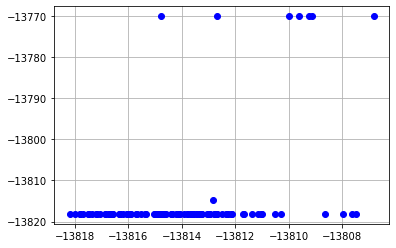

In [27]:
plt.plot(test_labels,prediction, 'o', color='blue')
plt.grid()
#plt.xlim([min(test_labels), max(test_labels)])
#plt.ylim([min(prediction), max(prediction)])
#plt.ylim([-13822,-13800])


In [28]:
print('layer 1')
print('weights')
print(net.network1.fc1.weight)
print('biases')
print(net.network1.fc1.bias)

print('layer 2')
print('weights')
print(net.network1.fc2.weight)
print('biases')
print(net.network1.fc2.bias)

layer 1
weights
Parameter containing:
tensor([[ 3.3883, -4.0098,  2.7965,  ..., -4.2508,  0.3871, -4.1270],
        [ 1.4478, -0.4200,  1.4139,  ..., -0.3728,  2.5077, -0.2792],
        [ 1.2913, -0.2553,  1.3573,  ..., -0.2343,  2.5788, -0.3170],
        ...,
        [-5.8129,  1.3981, -3.0450,  ...,  0.7896, -0.1684,  1.2550],
        [-1.3286,  0.5670, -1.5638,  ...,  0.6819, -2.5874,  0.5239],
        [ 1.6920, -1.1461,  1.3239,  ..., -1.4182, -1.5101, -1.1358]],
       requires_grad=True)
biases
Parameter containing:
tensor([-4.2098, -1.3704, -1.4588, -1.5231, -1.4683, -3.7479,  3.5391,  4.4072,
         1.3009,  3.2459, -3.1951, -1.4414,  1.5271,  3.6500,  2.9839,  3.6990,
        -4.0264,  1.4427,  1.3323,  3.1687,  3.4341,  2.8224, -4.0809,  1.3291,
         1.3154, -5.8437,  3.7867, -3.4802,  3.4249, -3.6879, -4.1504,  6.2723,
         4.5972, -3.3666,  4.0068,  3.0345, -1.2984,  4.3784,  1.6077, -2.3402],
       requires_grad=True)
layer 2
weights
Parameter containing:
tensor

In [29]:
print(heta)
print(Rs)
print(zeta)
print(lambdaa)

[0.30191489 0.45829787 0.07255319 0.06212766 0.01       0.12468085
 0.44787234 0.18723404 0.35404255 0.19765957 0.5        0.34361702
 0.40617021 0.24978723 0.22893617 0.2706383  0.02042553 0.43744681
 0.42702128 0.38531915 0.47914894 0.15595745 0.37489362 0.10382979
 0.05170213 0.11425532 0.08297872 0.17680851 0.20808511 0.13510638
 0.16638298 0.36446809 0.32276596 0.41659574 0.2393617  0.14553191
 0.03085106 0.0412766  0.39574468 0.28106383 0.29148936 0.48957447
 0.21851064 0.09340426 0.4687234  0.26021277 0.31234043 0.33319149]
[0.23404255 0.63829787 0.14893617 0.57446809 0.46808511 0.61702128
 0.         0.19148936 0.87234043 0.42553191 0.34042553 0.95744681
 1.         0.12765957 0.44680851 0.06382979 0.55319149 0.85106383
 0.91489362 0.68085106 0.89361702 0.0212766  0.25531915 0.72340426
 0.29787234 0.93617021 0.04255319 0.08510638 0.80851064 0.17021277
 0.9787234  0.40425532 0.76595745 0.53191489 0.4893617  0.65957447
 0.10638298 0.70212766 0.27659574 0.74468085 0.36170213 0.319

In [ ]:
a = np.array([0.18723404, 0.17680851 ,0.32276596 ,0.2393617,  0.20808511, 0.34361702,
 0.21851064 ,0.31234043, 0.22893617, 0.07255319, 0.08297872, 0.19765957,
 0.24978723, 0.36446809, 0.10382979, 0.16638298, 0.37489362, 0.29148936,
 0.45829787, 0.28106383, 0.13510638 ,0.38531915 ,0.02042553 ,0.44787234,
 0.2706383 , 0.41659574, 0.09340426 ,0.03085106 ,0.4687234,  0.01,
 0.48957447, 0.35404255 ,0.42702128,0.47914894 ,0.5 ,       0.39574468,
 0.05170213 ,0.06212766 ,0.11425532, 0.30191489, 0.26021277, 0.0412766,
 0.15595745 ,0.12468085,0.33319149, 0.40617021 ,0.14553191, 0.43744681])

In [ ]:
b = np.array([0.44680851 ,0.76595745, 0.74468085, 0.38297872, 0.57446809, 0.61702128,
 0.53191489, 0.59574468, 0.0212766,  0.19148936, 0.70212766, 0.25531915,
 0.36170213, 0.14893617 ,0.42553191, 0.72340426, 0.04255319, 0.68085106,
 0.87234043, 0.93617021, 1.,         0.40425532, 0.46808511, 0.91489362,
 0.34042553, 0.23404255, 0.63829787, 0.65957447, 0.10638298, 0.78723404,
 0.21276596, 0.55319149, 0.5106383,  0.08510638, 0.06382979, 0.27659574,
 0.,         0.95744681, 0.80851064 ,0.12765957, 0.17021277, 0.85106383,
 0.4893617,  0.82978723, 0.29787234, 0.89361702, 0.31914894, 0.9787234 ])

In [ ]:
c = np.array([0.32978723, 0.21276596, 0.19148936, 0.25531915 ,0.4787234,  0.38297872,
 0.29787234 ,0.28723404 ,0.34042553, 0.40425532 ,0.20212766, 0.10638298,
 0.04255319 ,0.43617021, 0.30851064, 0.07446809 ,0.27659574 ,0.05319149,
 0.09574468 ,0.17021277, 0.46808511 ,0.0212766 , 0.13829787, 0.42553191,
 0.23404255 ,0.24468085 ,0.35106383, 0.4893617 , 0.45744681, 0.0106383,
 0.44680851 ,0.         ,0.26595745, 0.15957447 ,0.08510638 ,0.36170213,
 0.12765957 ,0.39361702 ,0.18085106, 0.03191489, 0.11702128 ,0.5,
 0.22340426 ,0.41489362 ,0.31914894 ,0.37234043, 0.06382979, 0.14893617])